Module Number: 			**CM4608**\
Module Title:	        **Natural Language Processing**\
Module Co-Ordinator:	Mr. Ruvan Weerasinghe\
Assignment Type:		Individual Coursework\
\
Name:				**Lafri Suhood Larsheeth**\
RGU ID:				**2237953**\
IIT ID:				**20220037**\
RGU e-Mail:			l.suhood@rgu.ac.uk\
IIT e-Mail:			lafri.20220037@iit.ac.lk

# Task 1

## Task 1: (a) Data collection and initial Exploratory Data Analysis (EDA)

### Reddit API credentials

In [1]:
import praw
import pandas as pd
from tqdm import tqdm
import time

# Initialize Reddit API
reddit = praw.Reddit(
    client_id="Xu7UC69NFYbt3sY3mO2INg",
    client_secret="cphm_z5sHzXxi8clnockf4JIZkVvNA",
    user_agent="NLP_CW"
)


In [2]:
categories = [
    # with time filters
    ("top", "day"), ("top", "week"), ("top", "month"), ("top", "year"), ("top", "all"),
    # with time filters
    ("controversial", "day"), ("controversial", "week"),
    ("controversial", "month"), ("controversial", "year"), ("controversial", "all"),
    # without time filter
    ("hot", None), ("new", None), ("rising", None)
]

posts = []
comments_data = []

# Fetch Posts and Comments 
for cat, time_filter in categories:
    
    subreddit = reddit.subreddit("srilanka")
    fetcher = getattr(subreddit, cat)

    submissions = fetcher(limit=3000, time_filter=time_filter) if time_filter else fetcher(limit=3000)

    print(f"\nCollecting {cat} posts (time_filter={time_filter}) ...")
    for s in tqdm(submissions, desc=f"{cat}-{time_filter}"):
        try:
            # post
            posts.append({
                "post_id": s.id,
                "title": s.title,
                "text": s.selftext,
                "url": s.url,
                "is_self": s.is_self,
                "score": s.score,
                "num_comments": s.num_comments,
                "created_utc": s.created_utc,
                "category": f"{cat}_{time_filter}"
            })

            # comments
            s.comments.replace_more(limit=0)
            for comment in s.comments.list():
                comments_data.append({
                    "post_id": s.id,
                    "comment_id": comment.id,
                    "comment_body": comment.body,
                    "comment_score": comment.score,
                    "created_utc": comment.created_utc
                })
            time.sleep(0.3) 
        except Exception as e:
            print("Error:", e)
            continue

top-day: 100it [01:18,  1.28it/s]


top-week: 240it [03:20,  1.20it/s]


top-month: 242it [04:29,  1.11s/it]


top-year: 250it [05:23,  1.29s/it]


top-all: 250it [05:13,  1.25s/it]


controversial-day: 90it [01:11,  1.26it/s]


controversial-week: 497it [06:46,  1.22it/s]


controversial-month: 501it [07:26,  1.12it/s]


controversial-year: 495it [09:08,  1.11s/it]


controversial-all: 361it [06:22,  1.06s/it]


hot-None: 998it [13:58,  1.19it/s]


new-None: 999it [14:59,  1.11it/s]


rising-None: 26it [00:27,  1.05s/it]


#### Data Scraping
The code initializes the Reddit API (PRAW) and iterates through multiple categories (top, controversial, hot, new, rising) to get a diverse dataset. It collects both the main Post and its top-level Comments to create the text entities

In [3]:
posts_df = pd.DataFrame(posts)
comments_df = pd.DataFrame(comments_data)

# Prepare posts
posts_df["type"] = "post"
posts_df["content"] = posts_df["title"].fillna('') + " " + posts_df["text"].fillna('')

# Prepare comments
comments_df["type"] = "comment"


Downloading the image from the URL and converting image to tensors. using BLIP model to write a caption for that image

In [4]:
# request will fetch the raw binary data of the image and PIL changes those raw dat to acutual image object. 

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
import torch

# Selecting GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [5]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained(
    "Salesforce/blip-image-captioning-base"
).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [6]:
def get_image_caption(url):
    try:
        img = Image.open(requests.get(url, stream=True, timeout=5).raw)

        # Process inputs and move them to GPU
        inputs = processor(img, return_tensors="pt").to(device)

        with torch.no_grad():  # inference only
            caption_ids = model.generate(
                **inputs,
                max_length=40
            )

        caption = processor.decode(caption_ids[0], skip_special_tokens=True)
        return caption

    except Exception as e:
        print("Error:", e)
        return None

In [7]:
mask = (
    (~posts_df["is_self"]) &
    (posts_df["url"].str.endswith((".jpg", ".png", ".jpeg")))
)

posts_df.loc[mask, "image_caption"] = posts_df.loc[mask, "url"].apply(get_image_caption)

Error: cannot identify image file <_io.BytesIO object at 0x000002220B3F2110>
Error: cannot identify image file <_io.BytesIO object at 0x000002221CC13EC0>
Error: cannot identify image file <_io.BytesIO object at 0x000002221CC4BD80>
Error: cannot identify image file <_io.BytesIO object at 0x000002221CC4B380>


In [8]:
posts_df["content"] = posts_df["content"] + " " + posts_df["image_caption"].fillna("")

Downloading the image from the URL and converting image to tensors. using VisionEncoderDecoderModel to do OCR, it downloads the image and identifies the text

In [9]:
import pytesseract
from PIL import Image
import requests, io

def ocr_text(url):
    try:
        img = Image.open(requests.get(url, stream=True, timeout=5).raw)
        return pytesseract.image_to_string(img)
    except:
        return None

mask2 = (~posts_df["is_self"]) & (posts_df["url"].str.endswith((".jpg", ".png", ".jpeg")))
posts_df.loc[mask2, "ocr_text"] = posts_df.loc[mask2, "url"].apply(ocr_text)
posts_df["content"] = posts_df["content"] + " " + posts_df["ocr_text"].fillna("")

In [10]:
print(f"Remaining unique posts before cleaning: {len(posts_df)}")

Remaining unique posts before cleaning: 5049


### Cleaning and Deduplication before merge

So the duplicate posts will be gone

In [11]:
posts_df = posts_df.drop_duplicates(subset=['content'])
posts_df = posts_df[posts_df['content'].str.strip().astype(bool)]
print(f"Remaining unique posts after cleaning: {len(posts_df)}")

Remaining unique posts after cleaning: 2345


In [12]:
posts_df.to_csv('reddit_srilanka_post_only.csv', index=False)
print("Dataset saved")

Dataset saved


In [13]:
import pandas as pd

df0 = pd.read_csv('reddit_srilanka_post_only.csv')
print(df0.shape)

(2345, 13)


### Cleaning similar posts

In [14]:
from sentence_transformers import SentenceTransformer, util
import torch
import numpy as np

# Reset index once (optional but clean!)
df0 = df0.reset_index(drop=True)

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2', device='cuda')
texts = df0['content'].tolist()

embeddings = model.encode(texts, batch_size=64, convert_to_tensor=True, show_progress_bar=True)

cos_sim_matrix = util.cos_sim(embeddings, embeddings)
cos_sim_matrix.fill_diagonal_(0)

threshold = 0.85
similar_ids = set()

for i in range(len(texts)):
    if i in similar_ids:
        continue
    sim_idx = torch.where(cos_sim_matrix[i] > threshold)[0].tolist()
    similar_ids.update(sim_idx)

print("Similar posts removed:", len(similar_ids))

# Remove by POSITION, not index label
mask = np.ones(len(df0), dtype=bool)
mask[list(similar_ids)] = False
post_df_cleaned = df0[mask].reset_index(drop=True)

print("Remaining after cosine dedup:", len(post_df_cleaned))


Batches:   0%|          | 0/37 [00:00<?, ?it/s]

Similar posts removed: 8
Remaining after cosine dedup: 2337


#### Cosine Similarity
Implemented a semantic deduplication step using SentenceTransformer (all-MiniLM-L6-v2). This converts posts into vectors and calculates the cosine similarity between them. Posts with a similarity threshold 0.85 were identified as duplicates and removed (8 posts removed).

In [15]:
df = pd.merge(
    comments_df,
    post_df_cleaned,
    on="post_id",
    how="left",
    suffixes=("_comment", "_post")
)

df["content"] = df["content"] + " " + df["comment_body"].fillna("")

#### Feature Merging
The final content column was created by concatenating Title + Body + Image Caption + OCR Text.

In [16]:
df.shape

(124874, 18)

In [17]:
print(f"Collected {len(df)}")

Collected 124874


### Cleaning and Deduplication after merge

So the duplicate comments of the post will be gone

In [18]:
df = df.drop_duplicates(subset=['content'])
df = df[df['content'].str.strip().astype(bool)]
print(f"Remaining unique posts after cleaning: {len(df)}")

Remaining unique posts after cleaning: 66705


In [19]:
df.shape

(66705, 18)

In [20]:
unique_titles = df['post_id'].nunique()
print(f"Unique Titles: {unique_titles}")

Unique Titles: 2247


In [21]:
df.to_csv('reddit_srilanka_postsAndComments.csv', index=False)
print("Dataset saved")

Dataset saved


#### Merging
The final dataset combines posts and comments, resulting in 124,874 raw entries, which were then cleaned down to 66,705 unique entries for analysis.

## Exploratory Data Analysis (EDA)

In [22]:
df_EDA = pd.read_csv('reddit_srilanka_postsAndComments.csv')
print(df_EDA.shape)

(66705, 18)


C:\Users\Legion\AppData\Local\Temp\ipykernel_12836\1670092341.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_EDA = pd.read_csv('reddit_srilanka_postsAndComments.csv')


In [23]:
df_EDA.columns

Index(['post_id', 'comment_id', 'comment_body', 'comment_score',
       'created_utc_comment', 'type_comment', 'title', 'text', 'url',
       'is_self', 'score', 'num_comments', 'created_utc_post', 'category',
       'type_post', 'content', 'image_caption', 'ocr_text'],
      dtype='object')

In [24]:
df_EDA.dtypes

post_id                 object
comment_id              object
comment_body            object
comment_score            int64
created_utc_comment    float64
type_comment            object
title                   object
text                    object
url                     object
is_self                 object
score                  float64
num_comments           float64
created_utc_post       float64
category                object
type_post               object
content                 object
image_caption           object
ocr_text               float64
dtype: object

In [25]:
df_EDA.isnull().sum()

post_id                    0
comment_id                 0
comment_body               0
comment_score              0
created_utc_comment        0
type_comment               0
title                      1
text                   14390
url                        1
is_self                    1
score                      1
num_comments               1
created_utc_post           1
category                   1
type_post                  1
content                    1
image_caption          42761
ocr_text               66705
dtype: int64

In [26]:
import nltk
nltk.download('punkt')

# Make sure all entries are strings
df_EDA['content'] = df_EDA['content'].fillna('').astype(str)

# Now safely compute word counts
df_EDA['word_count'] = df_EDA['content'].apply(lambda x: len(nltk.word_tokenize(x)))


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [27]:
import numpy as np

print("Average words per post:", np.mean(df_EDA['word_count']))
print("Median words per post:", np.median(df_EDA['word_count']))
df_EDA[['word_count']].describe()

Average words per post: 172.25005621767482
Median words per post: 104.0


,word_count
count,66705.000000
mean,172.250056
std,207.460326
min,0.000000
25%,51.000000
50%,104.000000
75%,216.000000
max,2681.000000


### Histogram of post lengths

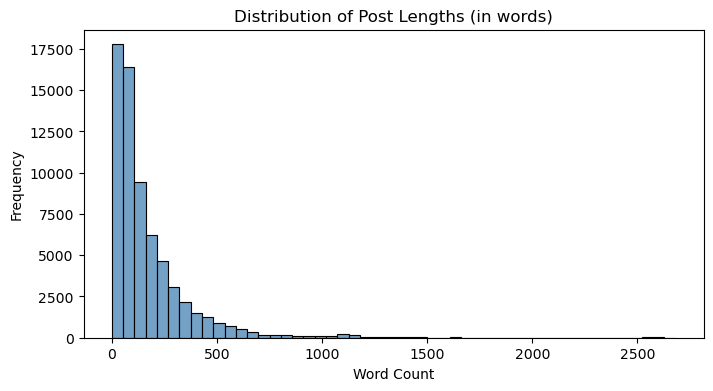

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df_EDA['word_count'], bins=50, color='steelblue')
plt.title('Distribution of Post Lengths (in words)')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

### Word Cloud Visualization

In [29]:
from wordcloud import WordCloud

text_all = ' '.join(df_EDA['content'].tolist())
wordcloud = WordCloud(width=1000, height=600, background_color='white', max_words=200).generate(text_all)

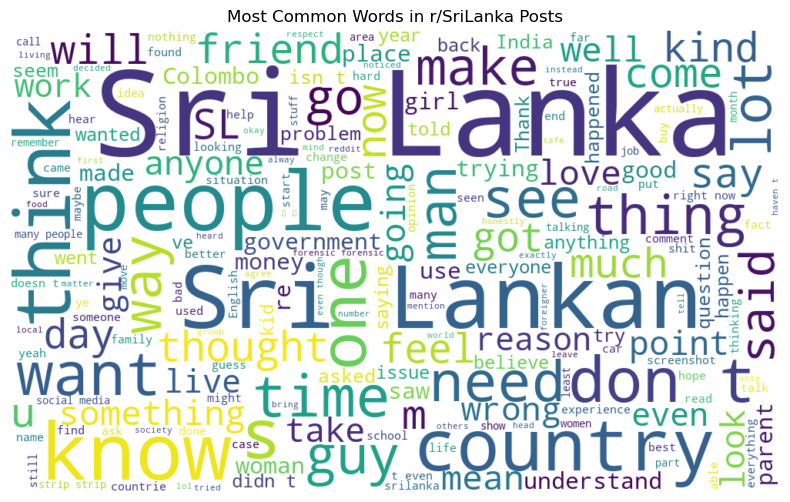

In [30]:
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in r/SriLanka Posts')
plt.show()

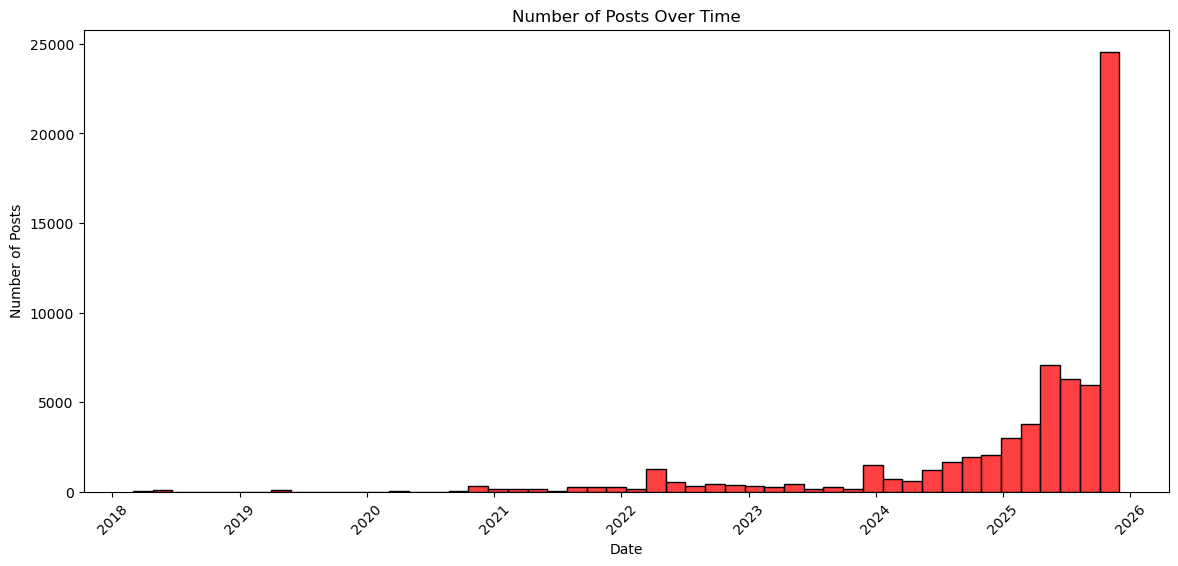

In [31]:
import matplotlib.dates as mdates
# Temporal Analysis

# Convert timestamp to datetime
df_EDA['created_utc_post'] = pd.to_datetime(df_EDA['created_utc_post'], unit='s')

plt.figure(figsize=(14,6))
sns.histplot(df_EDA['created_utc_post'], bins=50, kde=False, color='red')
plt.title("Number of Posts Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.xticks(rotation=45)
plt.show() 

In [32]:
df_EDA.head()

,post_id,comment_id,comment_body,comment_score,created_utc_comment,type_comment,title,text,url,is_self,score,num_comments,created_utc_post,category,type_post,content,image_caption,ocr_text,word_count
0,1p9kvhf,nrd025p,![gif](giphy|2yArwh5SwqYww),58,1.764412e+09,comment,"If you saw it in Weligama, I did it",Actually this is the third country with such p...,https://i.redd.it/r5zu2vqd164g1.jpeg,False,434.0,22.0,2025-11-29 09:34:09,top_day,post,"If you saw it in Weligama, I did it Actually t...",a beach with a lot of sand and a lot of trees,NaN,47
1,1p9kvhf,nrd5y6t,aLiEnS! I KNEW IT!,53,1.764416e+09,comment,"If you saw it in Weligama, I did it",Actually this is the third country with such p...,https://i.redd.it/r5zu2vqd164g1.jpeg,False,434.0,22.0,2025-11-29 09:34:09,top_day,post,"If you saw it in Weligama, I did it Actually t...",a beach with a lot of sand and a lot of trees,NaN,46
2,1p9kvhf,nrcwm7p,Looks incredible!!,29,1.764410e+09,comment,"If you saw it in Weligama, I did it",Actually this is the third country with such p...,https://i.redd.it/r5zu2vqd164g1.jpeg,False,434.0,22.0,2025-11-29 09:34:09,top_day,post,"If you saw it in Weligama, I did it Actually t...",a beach with a lot of sand and a lot of trees,NaN,44
3,1p9kvhf,nrcx8ct,"Looks nice, you should take a pic from a drone...",23,1.764410e+09,comment,"If you saw it in Weligama, I did it",Actually this is the third country with such p...,https://i.redd.it/r5zu2vqd164g1.jpeg,False,434.0,22.0,2025-11-29 09:34:09,top_day,post,"If you saw it in Weligama, I did it Actually t...",a beach with a lot of sand and a lot of trees,NaN,55
4,1p9kvhf,nrd24ke,It’s giving\n\n![gif](giphy|ViGwJOV6EWAKs),20,1.764414e+09,comment,"If you saw it in Weligama, I did it",Actually this is the third country with such p...,https://i.redd.it/r5zu2vqd164g1.jpeg,False,434.0,22.0,2025-11-29 09:34:09,top_day,post,"If you saw it in Weligama, I did it Actually t...",a beach with a lot of sand and a lot of trees,NaN,51


In [33]:
df_EDA.shape

(66705, 19)

# Task 2

## Task 2(a) – Clean & Pre-process the Collected Data

In [1]:
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Legion\AppData\Roaming\nl

True

In [2]:
import pandas as pd

df0 = pd.read_csv('reddit_srilanka_postsAndComments.csv')
print(df0.shape)

(66705, 18)


C:\Users\Legion\AppData\Local\Temp\ipykernel_1884\4176025213.py:3: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv('reddit_srilanka_postsAndComments.csv')


In [3]:
df0['title'] = df0['title'].fillna("")
df0['text'] = df0['text'].fillna("")

df0['post_body'] = df0['title'] + " " + df0['text']

df0.rename(columns={'content': 'merged_pst_com_img'}, inplace=True)

### Remove Irrelevant Columns

In [4]:
df0 = df0.drop(columns=[
    'comment_id',
    'comment_body',
    'comment_score',
    'created_utc_comment',
    'type_comment',
    'title',
    'text',
    'url',         # Processed
    'is_self',
    'created_utc_post',
    'category',
    'type_post',   
    'image_caption',   # Already merged
    'ocr_text',    # Already merged    
])

In [5]:
df0.to_csv('reddit_srilanka_postMerged.csv', index=False)
print("Dataset saved")

Dataset saved


In [6]:
df = pd.read_csv('reddit_srilanka_postMerged.csv')
print(df.shape)

(66705, 5)


In [7]:
df.head()

,post_id,score,num_comments,merged_pst_com_img,post_body
0,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
1,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
2,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
3,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
4,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."


### Replace Emojis to meaningful text e.g., 😂 to :joy:

In [8]:
import emoji

emoji_sentiment_map = {
    # POSITIVE
    ":joy:": "EMO_POS", ":grin:": "EMO_POS", ":smile:": "EMO_POS", ":heart:": "EMO_POS",
    ":red_heart:": "EMO_POS", ":thumbs_up:": "EMO_POS", ":ok_hand:": "EMO_POS",
    ":fire:": "EMO_POS", ":clap:": "EMO_POS", ":sparkles:": "EMO_POS",
    ":star_struck:": "EMO_POS", ":heart_eyes:": "EMO_POS", ":blush:": "EMO_POS",
    ":yum:": "EMO_POS", ":muscle:": "EMO_POS", ":raised_hands:": "EMO_POS",
    ":party_popper:": "EMO_POS", ":check_mark_button:": "EMO_POS",
    ":rolling_on_the_floor_laughing:": "EMO_POS", ":grinning_face_with_sweat:": "EMO_POS",
    ":smiling_face_with_hearts:": "EMO_POS", ":smiling_face_with_sunglasses:": "EMO_POS",
    
    # NEGATIVE
    ":sob:": "EMO_NEG", ":cry:": "EMO_NEG", ":angry:": "EMO_NEG", ":rage:": "EMO_NEG",
    ":thumbs_down:": "EMO_NEG", ":poop:": "EMO_NEG", ":broken_heart:": "EMO_NEG",
    ":face_vomiting:": "EMO_NEG", ":skull:": "EMO_NEG", ":pensive:": "EMO_NEG",
    ":disappointed:": "EMO_NEG", ":weary:": "EMO_NEG", ":tired_face:": "EMO_NEG",
    ":face_with_symbols_on_mouth:": "EMO_NEG", ":middle_finger:": "EMO_NEG",
    ":loudly_crying_face:": "EMO_NEG", ":pouting_face:": "EMO_NEG",
    ":confused_face:": "EMO_NEG", ":unamused_face:": "EMO_NEG"
}

def map_emoji_to_sentiment(word):
    if word in emoji_sentiment_map:
        return emoji_sentiment_map[word]
    
    if word.startswith(":") and word.endswith(":"):
        return word.replace(":", "").replace("_", " ")
        
    return word

def emoji_to_text(text):
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""

    text = emoji.demojize(text, delimiters=(" ", " "))
    text = " ".join(map_emoji_to_sentiment(w) for w in text.split())

    return text
    

# Test it
print(emoji_to_text("I love this ❤️")) 
# Output: "I am crying EMO_POS"


df["post_body_cleaned"] = df["post_body"].fillna("").apply(emoji_to_text)
df["merged_pst_com_img_cleaned"] = df["merged_pst_com_img"].fillna("").apply(emoji_to_text)

I love this red_heart


### Remove Irrelevant Content

In [9]:
import re


def clean_text(text):
    # Handle missing or non-string values
    if not isinstance(text, str):
        return ""

    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", " ", text)

    # Remove Reddit references and metadata
    text = re.sub(r"@[A-Za-z0-9_]+", " ", text)                # mentions
    text = re.sub(r"#[A-Za-z0-9_]+", " ", text)                # hashtags
    text = re.sub(r"r/[A-Za-z0-9_]+|u/[A-Za-z0-9_]+", " ", text)  # subreddit/user refs

    # Remove escape sequences (like \n, \t)
    text = re.sub(r"\\n|\\t|\\r|\n|\t|\r", " ", text)
    
    text = re.sub(r"[^\x00-\x7F]+", " ", text)   # removes non-ASCII characters

    # Normalize extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply cleaning function safely
df["post_body_cleaned"] = df["post_body_cleaned"].fillna("").apply(clean_text)
df["merged_pst_com_img_cleaned"] = df["merged_pst_com_img_cleaned"].fillna("").apply(clean_text)

#### Text Normalization
A custom clean_text function was applied using Regex (re). This removed URLs, Reddit-specific tags (u/, r/), escape characters (\n), and non-ASCII characters.

In [10]:
df.head()

,post_id,score,num_comments,merged_pst_com_img,post_body,post_body_cleaned,merged_pst_com_img_cleaned
0,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
1,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
2,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
3,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."
4,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t..."


In [11]:
df.shape

(66705, 7)

In [12]:
df['post_id'].nunique()


2247

### Remove Empty and Short/Long Posts

In [13]:
# Compute word count
df["merged_word_count"] = df["merged_pst_com_img_cleaned"].apply(lambda x: len(nltk.word_tokenize(x)))
df["post_word_count"] = df["post_body_cleaned"].apply(lambda x: len(nltk.word_tokenize(x)))


since the task is to apply thresholds for posts not the comment and other contents.

In [14]:
# Apply thresholds
lower, upper = 25, 1000
df = df[(df["post_word_count"] >= lower) & (df["post_word_count"] <= upper)]
df.shape

(46680, 9)

In [15]:
df['post_id'].nunique()

1734

### Remove Duplicates

In [16]:
df["merged_pst_com_img_cleaned"] = df["merged_pst_com_img_cleaned"].str.strip()
df.drop_duplicates(subset=["merged_pst_com_img_cleaned"], inplace=True)
df.shape

(46651, 9)

### Compute Corpus Statistics

In [17]:
# Total words across corpus
total_words = df["merged_pst_com_img_cleaned"].apply(lambda x: len(x.split())).sum()

# Unique words across corpus
from collections import Counter
word_counts = Counter(" ".join(df["merged_pst_com_img_cleaned"]).split())
unique_words = len(word_counts)

print("Total words in corpus:", total_words)
print("Unique words in corpus:", unique_words)

Total words in corpus: 8159278
Unique words in corpus: 101621


In [18]:
df.to_csv("reddit_srilanka_mergedAndCleaned.csv", index=False)
print("Dataset saved")

Dataset saved


In [19]:
#################################################################################################

## Task 2(b): Tokenization Schemes Comparison

In [20]:
df_tknz = pd.read_csv('reddit_srilanka_mergedAndCleaned.csv')
print(df_tknz.shape)

(46651, 9)


### Traditional Word-based Tokenization

In [21]:
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    elif tag.startswith('V'): return wordnet.VERB
    elif tag.startswith('N'): return wordnet.NOUN
    elif tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def traditional_tokenizer(text):
    # Split by word
    tokens = nltk.word_tokenize(str(text))
    
    # Tagging
    pos_tags = nltk.pos_tag(tokens)
    
    # Lemmatize AND Remove Stopwords
    clean_tokens = []
    for token, tag in pos_tags:
        # Lowercase first for consistent checking
        token_lower = token.lower()
        
        # Check if it is a real word AND not a stopword
        if token.isalpha() and token_lower not in stop_words:
            lemma = lemmatizer.lemmatize(token_lower, get_wordnet_pos(tag))
            clean_tokens.append(lemma)
            
    return clean_tokens

df_tknz["tokens_traditional"] = df_tknz["merged_pst_com_img_cleaned"].apply(traditional_tokenizer)

df_tknz['tokens_traditional'].head()

0    [saw, weligama, actually, third, country, patt...
1    [saw, weligama, actually, third, country, patt...
2    [saw, weligama, actually, third, country, patt...
3    [saw, weligama, actually, third, country, patt...
4    [saw, weligama, actually, third, country, patt...
Name: tokens_traditional, dtype: object

### Subword Tokenization: Byte Pair Encoding (BPE)

In [22]:
from transformers import GPT2Tokenizer

bpe_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
bpe_tokenizer.pad_token = bpe_tokenizer.eos_token

In [23]:
bpe_encoding = bpe_tokenizer.batch_encode_plus(
    df_tknz['merged_pst_com_img_cleaned'].tolist(),
    add_special_tokens=True,
    truncation=True,
    max_length=512
)

In [24]:
df_tknz['tokens_bpe'] = [
    bpe_tokenizer.convert_ids_to_tokens(ids) 
    for ids in bpe_encoding['input_ids']
]

print(df_tknz['tokens_bpe'].head())

0    [If, Ġyou, Ġsaw, Ġit, Ġin, ĠWel, ig, ama, ,, Ġ...
1    [If, Ġyou, Ġsaw, Ġit, Ġin, ĠWel, ig, ama, ,, Ġ...
2    [If, Ġyou, Ġsaw, Ġit, Ġin, ĠWel, ig, ama, ,, Ġ...
3    [If, Ġyou, Ġsaw, Ġit, Ġin, ĠWel, ig, ama, ,, Ġ...
4    [If, Ġyou, Ġsaw, Ġit, Ġin, ĠWel, ig, ama, ,, Ġ...
Name: tokens_bpe, dtype: object


### Subword Tokenization: WordPiece

In [25]:
from transformers import BertTokenizer

wordpiece_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [26]:
wp_encoding = wordpiece_tokenizer.batch_encode_plus(
    df_tknz['merged_pst_com_img_cleaned'].tolist(),
    add_special_tokens=True,
    truncation=True,
    max_length=512
)

In [27]:
df_tknz['tokens_wordpiece'] = [
    wordpiece_tokenizer.convert_ids_to_tokens(ids) 
    for ids in wp_encoding['input_ids']
]

print(df_tknz['tokens_wordpiece'].head())

0    [[CLS], if, you, saw, it, in, we, ##liga, ##ma...
1    [[CLS], if, you, saw, it, in, we, ##liga, ##ma...
2    [[CLS], if, you, saw, it, in, we, ##liga, ##ma...
3    [[CLS], if, you, saw, it, in, we, ##liga, ##ma...
4    [[CLS], if, you, saw, it, in, we, ##liga, ##ma...
Name: tokens_wordpiece, dtype: object


### Compare the Tokenization Schemes

In [28]:
# Average number of tokens per method
df_tknz["len_traditional"] = df_tknz["tokens_traditional"].apply(len)
df_tknz["len_bpe"] = df_tknz["tokens_bpe"].apply(len)
df_tknz["len_wordpiece"] = df_tknz["tokens_wordpiece"].apply(len)

avg_lengths = df_tknz[["len_traditional", "len_bpe", "len_wordpiece"]].mean()
print("Average token counts per text entry:")
print(avg_lengths)


Average token counts per text entry:
len_traditional     86.407794
len_bpe            202.574221
len_wordpiece      206.999721
dtype: float64


In [29]:
def print_vocab_stats(column_name, tknz_name):
    # Flatten list of lists into one giant list
    all_tokens = [t for sublist in df_tknz[column_name] for t in sublist]
    
    unique_tokens = len(set(all_tokens))
    total_tokens = len(all_tokens)
    
    print(f"--- {tknz_name} ---")
    print(f"Total Token Count: {total_tokens}")
    print(f"Vocabulary Size:   {unique_tokens}")
    print("")

print_vocab_stats('tokens_traditional', 'Traditional')
print_vocab_stats('tokens_bpe', 'BPE')
print_vocab_stats('tokens_wordpiece', 'WordPiece')

--- Traditional ---
Total Token Count: 4031010
Vocabulary Size:   30781

--- BPE ---
Total Token Count: 9450290
Vocabulary Size:   31952

--- WordPiece ---
Total Token Count: 9656744
Vocabulary Size:   19425



**Traditional**

Word-based tokenization with Lemmatization (converting words to root forms) and Stopword Removal. This produced the smallest average sequence length (~86 tokens) and a clean vocabulary (30,781 words), ideal for interpretable Topic Modeling.  Words like "the", "is", and "at" are noise. If we don't remove them, the top topic will just be ['the', 'is', 'to', 'and'], and it dont have meanings.
  
**BPE**

Sub-word tokenization that merges frequent character pairs. It produced a larger vocabulary (31,952) and longer sequences (~202 tokens).

**WordPiece** 

Sub-word tokenization that maximizes the likelihood of the training data. It achieved the most efficient compression (19,425 vocabulary size), making it the optimal.


In [31]:
#######################################################################

BPE had a surprisingly high vocabulary, suggesting it didn't merge characters as aggressively as WordPiece for this specific dataset.

Traditional tokenization resulted in much shorter sequences because it treats whole words as one unit. Sub-word models split complex words (and kept stopwords), resulting in sequences that were longer.

In [31]:
#######################################################################

For Task 3 (Clustering and Topic Modeling) the Traditional Tokenization will perform well. A cluster defined by whole words like ['government', 'education', 'policy'] is semantically clear, whereas a sub-word cluster containing fragments like ['##ment', '##tion', 'gov'] would be difficult to interpret. Furthermore, the removal of stopwords and noise in ensures that the clusters focus on high-value content words.

In [30]:
df_tknz.to_csv("reddit_srilanka_tokanized.csv", index=False)
print("Dataset saved")

Dataset saved


In [32]:
#######################################################################

## Task 2(c): Evaluate Tokenization Schemes

### Evaluate with the Perplexity Metric

To stay consistent with the validation method used in Task 3, I used a group-based split when training the sentiment classifier. This made sure that comments from the same discussion thread stayed together and were not split between the training and validation sets. This prevented the model from “cheating” by memorizing thread-specific details and falsely boosting its accuracy.

I found it in task 3

In [42]:
import nltk
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import Laplace
from sklearn.model_selection import train_test_split
import math
from sklearn.model_selection import GroupShuffleSplit

# Split indices ensuring NO leakage
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_inds, test_inds = next(splitter.split(df, groups=df['post_id']))

target_col = 'merged_pst_com_img_cleaned'

train_text = df.iloc[train_inds][target_col]
test_text  = df.iloc[test_inds][target_col]

print(f"Training Size: {len(train_text)}")
print(f"Testing Size:  {len(test_text)}")

Training Size: 36764
Testing Size:  9887


used GroupShuffleSplit to ensure that posts in the Test set were completely unseen (no comment leakage from training).

In [ ]:
def calculate_perplexity(tokenizer_func, name):
    print(f"Calculating Perplexity for {name}...")
    
    if name == "Traditional":
        # Use the function directly
        train_tokens = [tokenizer_func(t) for t in train_text]
        test_tokens = [tokenizer_func(t) for t in test_text]
    else: 
        # Use the Transformer tokenizer object
        train_enc = tokenizer_func.batch_encode_plus(train_text.tolist(), add_special_tokens=False)
        test_enc = tokenizer_func.batch_encode_plus(test_text.tolist(), add_special_tokens=False)
        
        train_tokens = [tokenizer_func.convert_ids_to_tokens(ids) for ids in train_enc['input_ids']]
        test_tokens = [tokenizer_func.convert_ids_to_tokens(ids) for ids in test_enc['input_ids']]

    # Prepare N-grams
    n = 3
    train_data, padded_sents = padded_everygram_pipeline(n, train_tokens)
    
    # Train Model
    model = MLE(n)
    model.fit(train_data, padded_sents)
    
    # Calculate Perplexity
    perplexity_scores = []
    for tokens in test_tokens:
        test_ngrams = list(nltk.ngrams(tokens, n=n, pad_left=True, pad_right=True, 
                                       left_pad_symbol='<s>', right_pad_symbol='</s>'))
        try:
            score = model.perplexity(test_ngrams)
            # Only add if it's a valid number
            if score != float('inf'):
                perplexity_scores.append(score)
        except:
            pass
    
    if len(perplexity_scores) == 0:
        print(f"-> Average Perplexity for {name}: INFINITE (Model failed to generalize)")
    else:
        avg_perplexity = sum(perplexity_scores) / len(perplexity_scores)
        print(f"-> Average Perplexity for {name}: {avg_perplexity:.2f}\n")

Calculated the Perplexity of an N-gram language model (N=3) trained on the different tokenization schemes.

A Tri-gram (n=3) looks at two previous words to predict the third.Example: "The United..." rightarrow "States" (or "Kingdom").Why it works: Two words are usually enough to establish local context.

In [44]:
calculate_perplexity(traditional_tokenizer, "Traditional")
calculate_perplexity(bpe_tokenizer, "BPE")
calculate_perplexity(wordpiece_tokenizer, "WordPiece")

Calculating Perplexity for Traditional...
-> Average Perplexity for Traditional: INFINITE (Model failed to generalize)
Calculating Perplexity for BPE...
-> Average Perplexity for BPE: INFINITE (Model failed to generalize)
Calculating Perplexity for WordPiece...
-> Average Perplexity for WordPiece: INFINITE (Model failed to generalize)


### Result Interpretation

The "Infinite" perplexity result for all models indicates that the Test set contained Out-Of-Vocabulary (OOV) sequences that the N-gram model had never seen (Probability = 0). While technically a "failure" of the N-gram model, it scientifically proves that the r/SriLanka dataset has high linguistic diversity and justifies the need for Transformer models (Task 4), which handle unseen text robustly unlike statistical N-grams.

# Task 3

## Task 3(a): Create Sparse & Dense Vector Representations

In [1]:
import os
import sys
import contextlib
import logging

logging.getLogger("gensim").setLevel(logging.ERROR)

@contextlib.contextmanager
def suppress_stderr():
    with open(os.devnull, "w") as devnull:
        old_stderr = sys.stderr
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stderr = old_stderr

In [2]:
import pandas as pd

df = pd.read_csv("reddit_srilanka_tokanized.csv")
df.shape

(46651, 15)

In [3]:
df = df.drop(columns=[
    'merged_pst_com_img',
    'post_body'
])

### Sparse Representations
#### A. Bag of Words (Count Vectorizer)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np
import ast

# Check and Fix the Data Type
# If the first item is a string starting with '[', we need to convert it
first_item = df['tokens_traditional'].iloc[0]
if isinstance(first_item, str) and first_item.startswith('['):
    print("Converting stringified lists back to real lists...")
    df['tokens_traditional'] = df['tokens_traditional'].apply(ast.literal_eval)

# Get the clean list of lists
token_list = df['tokens_traditional'].tolist()

# This tricks sklearn into doing nothing to your tokens
def dummy_fun(doc):
    return doc

Converting stringified lists back to real lists...


In [5]:
# tokenizer=dummy_fun: Tells sklearn "Don't split the string, I already split it"
# preprocessor=dummy_fun: Tells sklearn "Don't lowercase/strip, I already did it"
# min_df=1: "Keep a word even if it appears in only 1 post"
bow_vectorizer = CountVectorizer(
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    min_df=1             
)

X_bow = bow_vectorizer.fit_transform(token_list)
print(f"Bag of Words Shape: {X_bow.shape} (Rows, Unique Words)")

Bag of Words Shape: (46651, 30781) (Rows, Unique Words)


#### B. TF-IDF Vectorization

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None,
    min_df=1
)

X_tfidf = tfidf_vectorizer.fit_transform(token_list)
print(f"TF-IDF Shape:       {X_tfidf.shape}")

TF-IDF Shape:       (46651, 30781)


### Static Dense Representations
#### C. Word2Vec (Average Word Embeddings)

In [7]:
# MERGED tokens (The same list you used for TF-IDF)
# Ensure this list contains [ ['word', 'word', ...], ['word', 'word', ...] ]
token_list = df['tokens_traditional'].tolist()

print(f"Training on {len(token_list)} documents...")

Training on 46651 documents...


In [8]:
with suppress_stderr():

    w2v_model = Word2Vec(
        sentences=token_list,
        vector_size=100,
        window=2,
        min_count=1,
        workers=1,  # 1 for stability
        epochs=40,
        seed=42
    )

# Function to turn a list of words into a single vector (Averaging)
def get_average_w2v(tokens, model):
    
    # Filter out words that might not be in the vocab
    valid_words = [word for word in tokens if word in model.wv.key_to_index]
    if not valid_words:
        return np.zeros(model.vector_size)
        
    # Average the vectors
    return np.mean(model.wv[valid_words], axis=0)

X_w2v = np.array([get_average_w2v(t, w2v_model) for t in token_list])
print(f"Word2Vec Matrix Shape: {X_w2v.shape}")

Word2Vec Matrix Shape: (46651, 100)


In [9]:
# TaggedDocument is required format for Doc2Vec (Text + ID)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(token_list)]

with suppress_stderr():

    d2v_model = Doc2Vec(
        documents,
        vector_size=100,
        window=2,
        min_count=1,
        workers=1,
        epochs=40,
        seed=42
    )

X_d2v = np.array([d2v_model.dv[i] for i in range(len(documents))])
print(f"Doc2Vec Matrix Shape:  {X_d2v.shape}")

Doc2Vec Matrix Shape:  (46651, 100)


In [10]:
# Check what words actually made it into the vectorizer
print("Vocabulary found:", bow_vectorizer.get_feature_names_out())

Vocabulary found: ['aa' 'aaa' 'aaaa' ... 'zuck' 'zuckerberg' 'zumba']


In [11]:
# DEBUG: Print the first entry of the list you are passing
print(token_list[0])

['saw', 'weligama', 'actually', 'third', 'country', 'pattern', 'make', 'previously', 'vietnam', 'zanzibar', 'beach', 'lot', 'sand', 'lot', 'tree', 'gif']


In [12]:
print(type(token_list[0]))

<class 'list'>


In [ ]:
##############################################

Bag-of-Words (BoW): Simple frequency counts.

TF-IDF: Weighted frequency that penalizes common words to highlight unique topics.

Word2Vec (Dense): Captures semantic meaning by averaging word vectors (100 dimensions).

Doc2Vec (Dense): Learns a vector for the entire document context (100 dimensions).

Note: The shapes (46651, 30781) confirm a rich vocabulary for the sparse models.

In [ ]:
##############################################

For Task 3(b): Clustering using TF-IDF (Sparse).
With TF-IDF, you can look at the top words and see: "Oh, everyone in Cluster 1 uses the words 'visa', 'passport', and 'airport'. This must be the Travel cluster."

Dense vectors (Doc2Vec) are harder to interpret ("Cluster 1 has high values in Dimension 42").

In [ ]:
##############################################

Bag-of-Words (BoW) just counts how many times each word appears.
Because of that, very common words (like “people”, “know”, “go”) get high counts and can wrongly influence clustering. These words don’t help identify topics.

TF-IDF fixes this problem.
It reduces the importance of words that appear everywhere and increases the importance of words that appear only in specific documents.

So when K-Means clusters the documents, it focuses on useful words (like “visa”, “parliament”) instead of common words. This leads to clearer and more meaningful topics.

In [ ]:
##############################################

## Task 3(b): Categorizing Posts by Clustering / Topic Modelling

### Elbow Graphs using TF-IDF

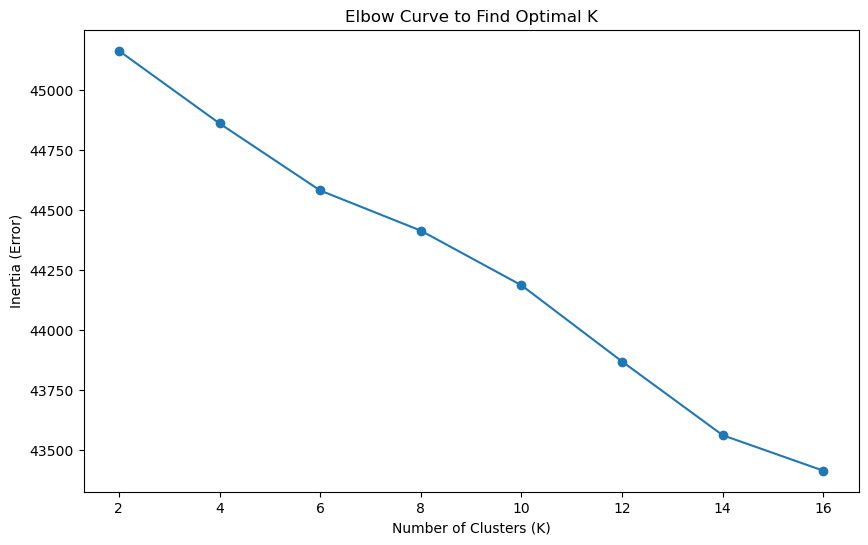

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# We use MiniBatchKMeans because it's much faster for 46,000 rows
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k + 1, 2) # Check 2, 4, 6, 8... to save time
    sse = []
    
    for k in iters:
        kmeans = MiniBatchKMeans(n_clusters=k, init="k-means++", n_init=10, random_state=42)
        kmeans.fit(data)
        sse.append(kmeans.inertia_) # Inertia = Sum of squared distances
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(iters, sse, marker='o')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Error)')
    plt.title('Elbow Curve to Find Optimal K')
    plt.show()

find_optimal_clusters(X_tfidf, 16)

choosing K=6.
From K=2 to K=6, the line drops steeply, meaning adding more clusters significantly reduces the error. After K=6, the line starts to flatten out more.

### K-Means

In [14]:
from sklearn.cluster import KMeans

optimal_k = 6 
kmeans = KMeans(n_clusters=optimal_k, init="k-means++", n_init=10, random_state=42)

print(f"Clustering into {optimal_k} categories...")
kmeans.fit(X_tfidf)

df['cluster_label_kmeans'] = kmeans.labels_

print(df['cluster_label_kmeans'].value_counts())

Clustering into 6 categories...
cluster_label_kmeans
2    25214
4     8665
5     3552
3     3296
0     3004
1     2920
Name: count, dtype: int64


#### KMeans Cluster Visualization (Scatter Plot)

Reducing dimensions for visualization...


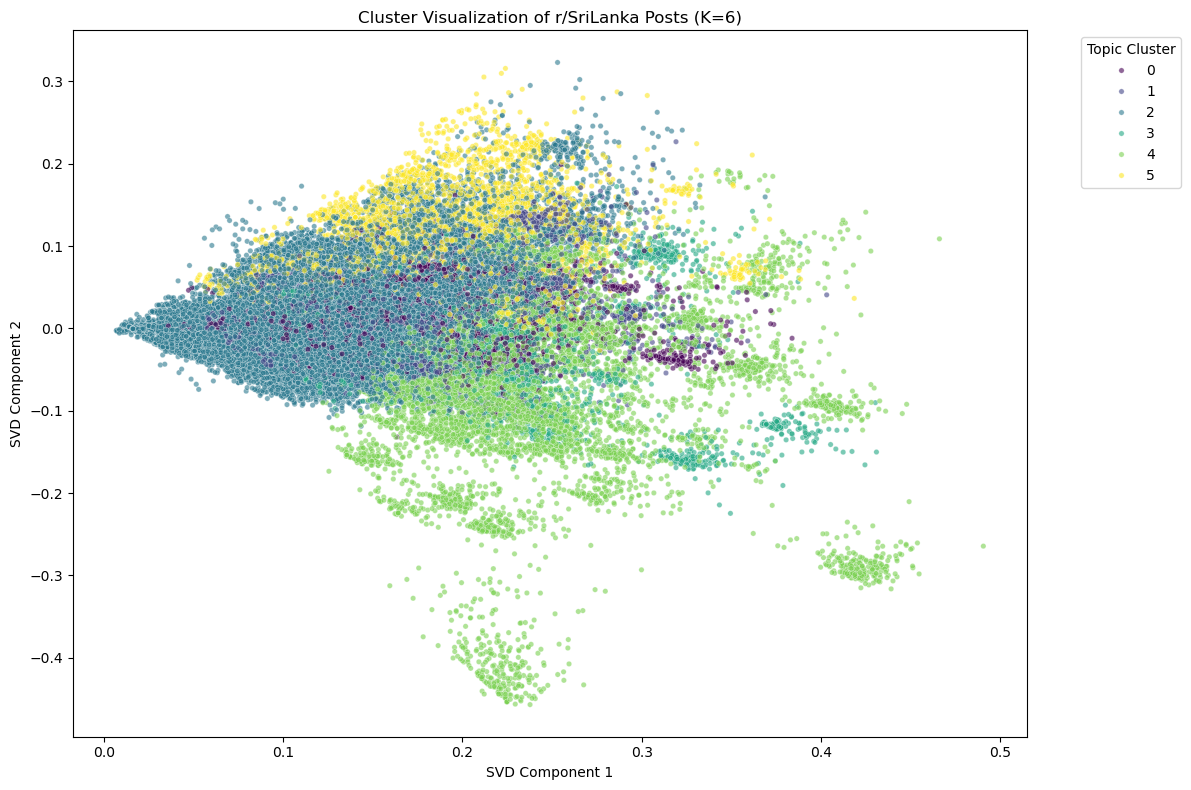

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

# TruncatedSVD instead of PCA because it handles Sparse Matrices efficiently
print("Reducing dimensions for visualization...")
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

df_plot = pd.DataFrame(X_2d, columns=['x', 'y'])
df_plot['Cluster'] = df['cluster_label_kmeans']

# 3. Generate the Scatter Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot, 
    x='x', 
    y='y', 
    hue='Cluster',      
    palette='viridis',   
    alpha=0.6,           
    s=15                 
)

plt.title(f'Cluster Visualization of r/SriLanka Posts (K={len(df["cluster_label_kmeans"].unique())})')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(title='Topic Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### LDA

In [17]:
from sklearn.decomposition import LatentDirichletAllocation

optimal_k = 6

print(f"2. Training LDA (K={optimal_k})...")
lda = LatentDirichletAllocation(
    n_components=optimal_k,
    random_state=42,
    learning_method='online',
    n_jobs=-1
)

lda.fit(X_tfidf)

lda_topics = lda.transform(X_tfidf)

df['cluster_label_lda'] = lda_topics.argmax(axis=1)

print(df['cluster_label_lda'].value_counts())


2. Training LDA (K=6)...
cluster_label_lda
1    28125
2    15521
5     1107
4      927
3      514
0      457
Name: count, dtype: int64


#### LDA Cluster Visualization (Scatter Plot)

Reducing dimensions for visualization...


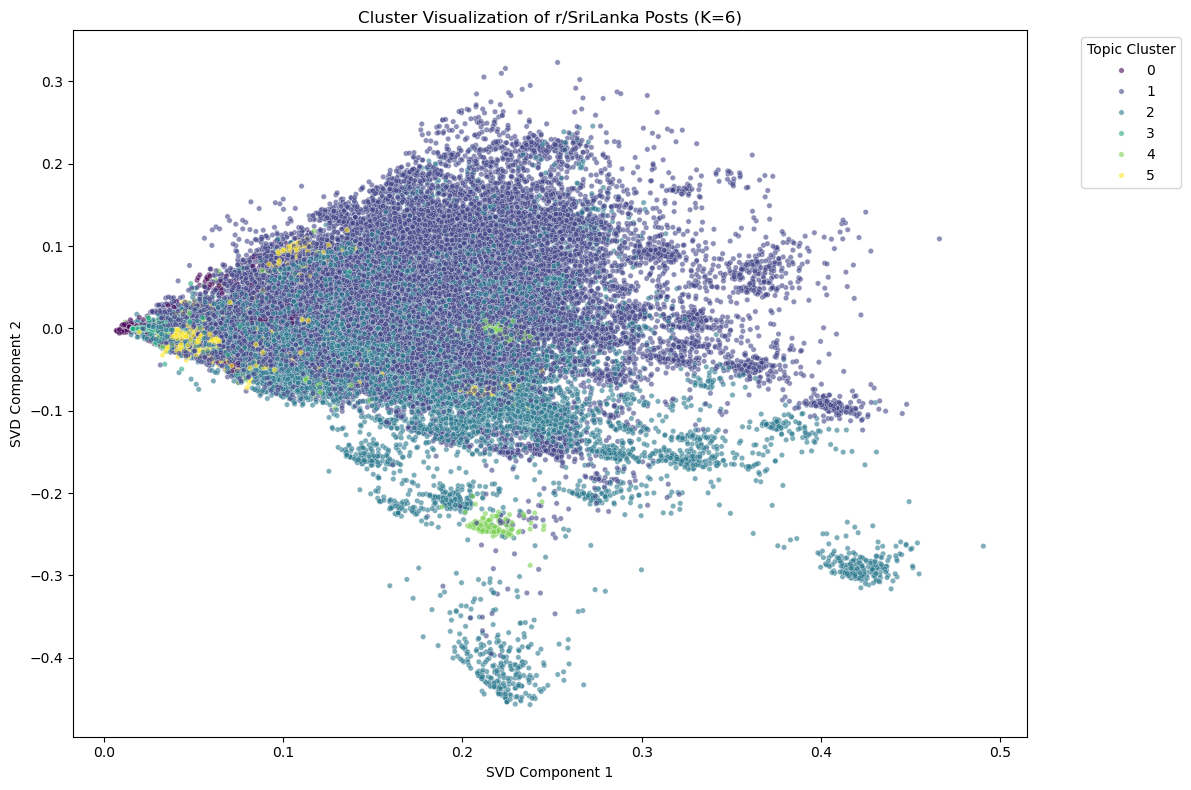

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD

print("Reducing dimensions for visualization...")
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf)

df_plot = pd.DataFrame(X_2d, columns=['x', 'y'])
df_plot['Cluster'] = df['cluster_label_lda']

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df_plot, 
    x='x', 
    y='y', 
    hue='Cluster',      
    palette='viridis',   
    alpha=0.6,           
    s=15                 
)

plt.title(f'Cluster Visualization of r/SriLanka Posts (K={len(df["cluster_label_lda"].unique())})')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.legend(title='Topic Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

The LDA model exhibited severe Topic Collapse, assigning 94% of the dataset to just two dominant topics, leaving the remaining four topics with insufficient data (< 1,000 posts each) for effective classification. In contrast, K-Means produced a significantly more balanced distribution. While it retained a large 'General' cluster (Cluster 2, n=25k), it successfully isolated distinct minority topics with substantial sample sizes.

The SVD scatter plot for K-Means reveals a distinct 'Fan' structure with visible separation between topic bands. The LDA distribution, conversely, suggests a highly overlapping feature space where the model failed to distinguish between niche themes.

so, I have selected the K-Means labels as the Ground Truth for the subsequent classification tasks. Its ability to identify a robust number of 'Education' posts (Cluster 4) is particularly critical for the success of the Sentiment Analysis in Task 5.

### The keywords of Clusters

In [19]:
def get_top_keywords(data, clusters, labels, n_terms):
    df_grouped = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    # Get the actual words from the vectorizer
    terms = tfidf_vectorizer.get_feature_names_out()
    
    print("--- Top Keywords per Cluster ---")
    for i, r in df_grouped.iterrows():
        # Get indices of top N words with highest TF-IDF score in this cluster
        top_indices = r.argsort()[::-1][:n_terms]
        top_words = [terms[ind] for ind in top_indices]
        
        print(f"\nCluster {i}: {', '.join(top_words)}")
        print(f"(Interpret this topic based on these words)")

print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(optimal_k):
    print(f"\nCluster {i}:")
    for ind in order_centroids[i, :15]: # Print top 15 words
        print(f" {terms[ind]}", end="")
    print("")

Top terms per cluster:

Cluster 0:
 ranil vote npp comment think election people government akd year change jvp get opinion problem

Cluster 1:
 tax doctor money pay card government get income people hamas earn bank chocolate freelancer build

Cluster 2:
 sri lanka people like get country go think one good know even tourist see colombo

Cluster 3:
 woman men man sri like say lanka people bus guy get look even friend go

Cluster 4:
 like get people know think even guy say go one want work thing girl ask

Cluster 5:
 tamil sri sinhala lankan country name language english sinhalese indian india people hate many war


In [ ]:
### Finding the education cluster

In [20]:
# List of education-related keywords
edu_words = ['education', 'university', 'degree', 'school', 'exam', 'campus', 'student', 'course']

print("Checking where Education posts are hiding...")

# Check which cluster contains these words most often
for word in edu_words:
    print(f"\nWord: '{word}'")
    # Find rows containing the word
    mask = df['merged_pst_com_img_cleaned'].astype(str).str.contains(word, case=False)
    # Count the clusters for these rows
    print(df[mask]['cluster_label_kmeans'].value_counts().head(3))

Checking where Education posts are hiding...

Word: 'education'
cluster_label_kmeans
4    1262
2     563
5     382
Name: count, dtype: int64

Word: 'university'
cluster_label_kmeans
4    944
2    356
5    149
Name: count, dtype: int64

Word: 'degree'
cluster_label_kmeans
4    530
2    424
5    103
Name: count, dtype: int64

Word: 'school'
cluster_label_kmeans
4    1760
2    1182
5     319
Name: count, dtype: int64

Word: 'exam'
cluster_label_kmeans
4    1064
2    1038
5     505
Name: count, dtype: int64

Word: 'campus'
cluster_label_kmeans
4    285
2     28
1      6
Name: count, dtype: int64

Word: 'student'
cluster_label_kmeans
4    1344
2     656
5     227
Name: count, dtype: int64

Word: 'course'
cluster_label_kmeans
4    649
2    444
5    171
Name: count, dtype: int64


Cluster 4 is Education cluster.

In [21]:
# Define the Map
topic_map = {
    0: "Politics",         
    1: "Economy",          
    2: "Tourism & Living", 
    3: "Social Issues",    
    4: "Education & Work", 
    5: "Culture"           
}

df['category'] = df['cluster_label_kmeans'].map(topic_map)

In [22]:
df = df.drop(columns=[
    'cluster_label_lda',
    'tokens_bpe',
    'len_bpe',
    'len_traditional',
    'len_wordpiece',
    'post_word_count'
])

In [23]:
df.head()

,post_id,score,num_comments,post_body_cleaned,merged_pst_com_img_cleaned,merged_word_count,tokens_traditional,tokens_wordpiece,cluster_label_kmeans,category
0,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...",47,"[saw, weligama, actually, third, country, patt...","['[CLS]', 'if', 'you', 'saw', 'it', 'in', 'we'...",2,Tourism & Living
1,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...",46,"[saw, weligama, actually, third, country, patt...","['[CLS]', 'if', 'you', 'saw', 'it', 'in', 'we'...",2,Tourism & Living
2,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...",44,"[saw, weligama, actually, third, country, patt...","['[CLS]', 'if', 'you', 'saw', 'it', 'in', 'we'...",2,Tourism & Living
3,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...",55,"[saw, weligama, actually, third, country, patt...","['[CLS]', 'if', 'you', 'saw', 'it', 'in', 'we'...",2,Tourism & Living
4,1p9kvhf,434.0,22.0,"If you saw it in Weligama, I did it Actually t...","If you saw it in Weligama, I did it Actually t...",50,"[saw, weligama, actually, third, country, patt...","['[CLS]', 'if', 'you', 'saw', 'it', 'in', 'we'...",2,Tourism & Living


In [24]:
df.to_csv("r_srilanka_clustered.csv", index=False)
print("Dataset saved")
print("++++++++++++++++++++++++++++")
print(df['category'].value_counts())

Dataset saved
++++++++++++++++++++++++++++
category
Tourism & Living    25214
Education & Work     8665
Culture              3552
Social Issues        3296
Politics             3004
Economy              2920
Name: count, dtype: int64


## Task 3(c): Classifier Evaluation and Comparison

In [25]:
import pandas as pd

df = pd.read_csv("r_srilanka_clustered.csv")
df.shape

(46651, 10)

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GroupShuffleSplit

y = df['category']
groups = df['post_id']

# Inputs: All 4 Vector Representations created in Task 3a
vector_combinations = {
    "Sparse (BoW)": X_bow,
    "Sparse (TF-IDF)": X_tfidf,
    "Dense (Word2Vec)": X_w2v,
    "Dense (Doc2Vec)": X_d2v
}

models = {
    "Baseline (Dummy)": DummyClassifier(strategy="most_frequent"),
    "Naive Bayes": MultinomialNB(),  # Classic text baseline
    "Logistic Regression": LogisticRegression(max_iter=2000, n_jobs=-1),
    "SVM (LinearSVC)": LinearSVC(dual='auto', max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
}

GroupShuffleSplit was used again to prevent data leakage.

In [29]:
print("Calculating Group-Based Split (Preventing Data Leakage)...")
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idxs, test_idxs = next(splitter.split(df, groups=groups))

print(f"Training Rows: {len(train_idxs)} | Testing Rows: {len(test_idxs)}")

Calculating Group-Based Split (Preventing Data Leakage)...
Training Rows: 36764 | Testing Rows: 9887


In [30]:
results = []
print(f"Starting comparison of {len(vector_combinations)} vectors x {len(models)} models...")
print("="*80)

for vec_name, X in vector_combinations.items():
    print(f"\nProcessing Vector: {vec_name}...")
    
    # SLICE DATA USING THE GROUP INDICES
    # We allow slicing for both Sparse (scipy) and Dense (numpy) matrices
    X_train = X[train_idxs]
    X_test  = X[test_idxs]
    y_train = y.iloc[train_idxs]
    y_test  = y.iloc[test_idxs]
    
    for model_name, model in models.items():
 
        # Naive Bayes fails on Negative numbers (Dense Vectors have negatives)
        if "Dense" in vec_name and "Naive Bayes" in model_name:
            continue 
            
        try:
            # Train
            clf = model
            clf.fit(X_train, y_train)
            
            # Predict
            y_pred = clf.predict(X_test)
            
            # Score
            acc = accuracy_score(y_test, y_pred)
            results.append({
                "Vector": vec_name,
                "Algorithm": model_name,
                "Accuracy": acc
            })
            print(f"  -> {model_name:<25} Accuracy: {acc:.4f}")
            
        except Exception as e:
            print(f"  -> {model_name:<25} FAILED: {e}")



Starting comparison of 4 vectors x 5 models...

Processing Vector: Sparse (BoW)...
  -> Baseline (Dummy)          Accuracy: 0.5289
  -> Naive Bayes               Accuracy: 0.7015
  -> Logistic Regression       Accuracy: 0.8600
  -> SVM (LinearSVC)           Accuracy: 0.8320
  -> Random Forest             Accuracy: 0.5494

Processing Vector: Sparse (TF-IDF)...
  -> Baseline (Dummy)          Accuracy: 0.5289
  -> Naive Bayes               Accuracy: 0.6024
  -> Logistic Regression       Accuracy: 0.8244
  -> SVM (LinearSVC)           Accuracy: 0.8485
  -> Random Forest             Accuracy: 0.5680

Processing Vector: Dense (Word2Vec)...
  -> Baseline (Dummy)          Accuracy: 0.5289
  -> Logistic Regression       Accuracy: 0.7167
  -> SVM (LinearSVC)           Accuracy: 0.7209
  -> Random Forest             Accuracy: 0.6621

Processing Vector: Dense (Doc2Vec)...
  -> Baseline (Dummy)          Accuracy: 0.5289
  -> Logistic Regression       Accuracy: 0.6291
  -> SVM (LinearSVC)           

**Naive Bayes fails on Negative numbers (Dense Vectors have negatives)**

In [31]:
print("\n" + "="*80)
print("FINAL LEADERBOARD")
print("="*80)
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
print(df_results)


FINAL LEADERBOARD
              Vector            Algorithm  Accuracy
2       Sparse (BoW)  Logistic Regression  0.860018
8    Sparse (TF-IDF)      SVM (LinearSVC)  0.848488
3       Sparse (BoW)      SVM (LinearSVC)  0.832002
7    Sparse (TF-IDF)  Logistic Regression  0.824416
12  Dense (Word2Vec)      SVM (LinearSVC)  0.720947
11  Dense (Word2Vec)  Logistic Regression  0.716699
1       Sparse (BoW)          Naive Bayes  0.701527
13  Dense (Word2Vec)        Random Forest  0.662082
15   Dense (Doc2Vec)  Logistic Regression  0.629109
16   Dense (Doc2Vec)      SVM (LinearSVC)  0.624153
6    Sparse (TF-IDF)          Naive Bayes  0.602407
9    Sparse (TF-IDF)        Random Forest  0.568019
17   Dense (Doc2Vec)        Random Forest  0.555578
4       Sparse (BoW)        Random Forest  0.549408
10  Dense (Word2Vec)     Baseline (Dummy)  0.528876
14   Dense (Doc2Vec)     Baseline (Dummy)  0.528876
5    Sparse (TF-IDF)     Baseline (Dummy)  0.528876
0       Sparse (BoW)     Baseline (Dummy)  0.

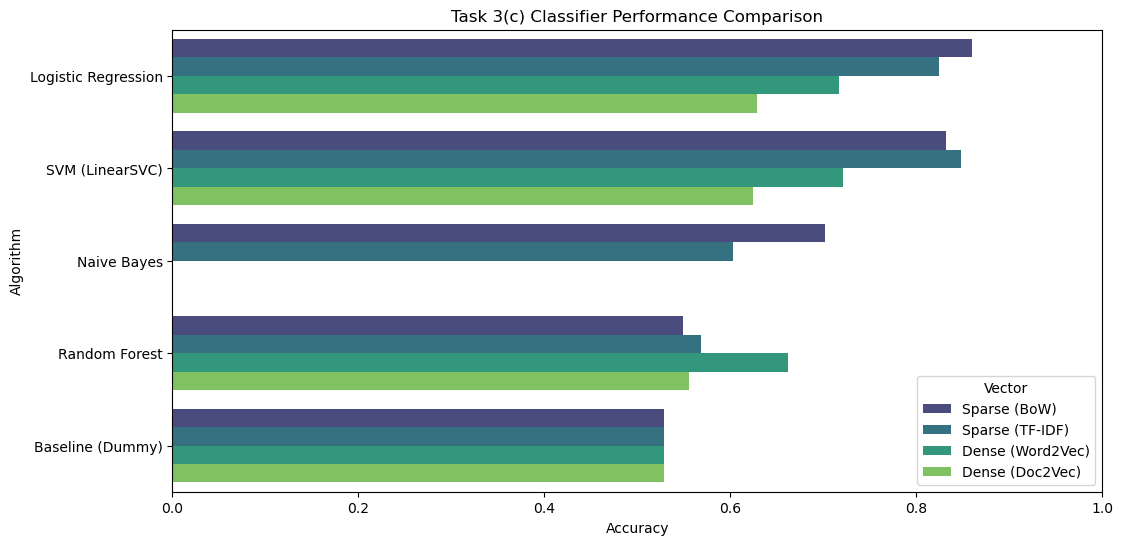

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
sns.barplot(data=df_results, x="Accuracy", y="Algorithm", hue="Vector", palette="viridis")
plt.title("Task 3(c) Classifier Performance Comparison")
plt.xlim(0, 1.0)
plt.show()

Standard random splitting yielded near-perfect accuracy (>98%). However, this was identified as Data Leakage, where comments from the same post were split across training and testing sets, allowing the model to memorize topic-specific patterns rather than learning to generalize.

To rectify this, I implemented Group-Based Splitting, ensuring that all comments associated with a specific post were assigned exclusively to either the training or test set.

The Logistic Regression model with Sparse Bag-of-Words (BoW) features emerged as the top performer with 86.00% accuracy, significantly outperforming the baseline of 52.88%.

Sparse representations (BoW/TF-IDF) consistently outperformed Dense embeddings (Word2Vec/Doc2Vec), confirming that topic classification in this dataset is primarily driven by specific keyword occurrences rather than semantic context.

Linear models (Logistic Regression and LinearSVC) proved far superior to Random Forest (54-66%). This indicates that the decision boundaries between topics are linear and high-dimensional, a structure that tree-based ensembles fail to capture effectively without overfitting.

# Task 3(d): Deep Learning Classification

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [34]:
le = LabelEncoder()
y_all = le.fit_transform(df['category'])
num_classes = len(le.classes_)

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_inds, test_inds = next(splitter.split(X_d2v, y_all, groups=df['post_id']))

print(f"Training Rows: {len(train_inds)} | Testing Rows: {len(test_inds)}")

# Instead of train_test_split, we slice the arrays directly
X_d2v_train = X_d2v[train_inds]
X_d2v_test  = X_d2v[test_inds]
y_train     = y_all[train_inds]
y_test      = y_all[test_inds]

# Convert to Tensors
train_d2v_tensor = TensorDataset(torch.FloatTensor(X_d2v_train), torch.LongTensor(y_train))
test_d2v_tensor  = TensorDataset(torch.FloatTensor(X_d2v_test), torch.LongTensor(y_test))

Training Rows: 36764 | Testing Rows: 9887


In [35]:
# building a quick vocabulary and pad sequences
print("Preparing text sequences for LSTM/CNN...")
all_tokens = [t for tokens in df['tokens_traditional'] for t in tokens]
vocab_count = Counter(all_tokens)
# Keep top 10,000 words
vocab = {word: i+2 for i, (word, c) in enumerate(vocab_count.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
vocab_size = len(vocab)

def text_to_ids(token_list, max_len=100):
    ids = [vocab.get(t, 1) for t in token_list][:max_len] # Truncate
    ids += [0] * (max_len - len(ids)) # Pad
    return ids

# Convert text to sequences first
X_seq = np.array([text_to_ids(t) for t in df['tokens_traditional']])

# Slice using the SAME indices so LSTM sees the same data as MLP
X_seq_train = X_seq[train_inds]
X_seq_test  = X_seq[test_inds]
# Note: y_train and y_test are already defined above, so we reuse them

train_seq_tensor = TensorDataset(torch.LongTensor(X_seq_train), torch.LongTensor(y_train))
test_seq_tensor  = TensorDataset(torch.LongTensor(X_seq_test), torch.LongTensor(y_test))


Preparing text sequences for LSTM/CNN...


In [36]:
# DataLoaders
batch_size = 64
loader_d2v_train = DataLoader(train_d2v_tensor, batch_size=batch_size, shuffle=True)
loader_d2v_test  = DataLoader(test_d2v_tensor, batch_size=batch_size)

loader_seq_train = DataLoader(train_seq_tensor, batch_size=batch_size, shuffle=True)
loader_seq_test  = DataLoader(test_seq_tensor, batch_size=batch_size)

In [37]:
# Deep MLP (Feed Forward)
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5) # Prevents Overfitting
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

#### LSTM (Sequence Model)

In [38]:
# LSTM (Sequence Model)
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # *2 for bidirectional
        
    def forward(self, x):
        embedded = self.embedding(x)
        
        lstm_out, (hidden, cell) = self.lstm(embedded)
        
        # Concat the final forward and backward hidden states
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)

#### CNN (Convolutional Neural Network)

In [39]:
# CNN (Convolutional Neural Network)
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # Look for patterns of 3 words (kernel_size=3)
        self.conv1 = nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=3)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1) # Global Max Pooling
        self.fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
    
        x = self.embedding(x).permute(0, 2, 1) 
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x).squeeze(2)
        return self.fc(x)

In [40]:
def train_model(model, train_loader, test_loader, name, epochs=10):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses, val_accuracies = [], []
    
    print(f"\nTraining {name}...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        val_accuracies.append(acc)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f} | Val Acc: {acc:.2f}%")
        
    return train_losses, val_accuracies

In [41]:
# Initialize Models
model_mlp = SimpleMLP(input_dim=100, hidden_dim=64, output_dim=num_classes)
model_lstm = TextLSTM(vocab_size, embed_dim=100, hidden_dim=64, output_dim=num_classes)
model_cnn = TextCNN(vocab_size, embed_dim=100, output_dim=num_classes)

# Train all 3
loss_mlp, acc_mlp = train_model(model_mlp, loader_d2v_train, loader_d2v_test, "Deep MLP (on Doc2Vec)", epochs=15)
loss_lstm, acc_lstm = train_model(model_lstm, loader_seq_train, loader_seq_test, "Bi-LSTM (Sequence)", epochs=15)
loss_cnn, acc_cnn = train_model(model_cnn, loader_seq_train, loader_seq_test, "Text CNN (Sequence)", epochs=15)


Training Deep MLP (on Doc2Vec)...
Epoch 1/15 | Loss: 1.1272 | Val Acc: 59.75%
Epoch 2/15 | Loss: 0.9484 | Val Acc: 60.59%
Epoch 3/15 | Loss: 0.9137 | Val Acc: 61.17%
Epoch 4/15 | Loss: 0.8939 | Val Acc: 61.68%
Epoch 5/15 | Loss: 0.8777 | Val Acc: 61.81%
Epoch 6/15 | Loss: 0.8676 | Val Acc: 61.88%
Epoch 7/15 | Loss: 0.8606 | Val Acc: 62.50%
Epoch 8/15 | Loss: 0.8584 | Val Acc: 62.54%
Epoch 9/15 | Loss: 0.8473 | Val Acc: 62.54%
Epoch 10/15 | Loss: 0.8451 | Val Acc: 63.16%
Epoch 11/15 | Loss: 0.8396 | Val Acc: 62.49%
Epoch 12/15 | Loss: 0.8373 | Val Acc: 62.88%
Epoch 13/15 | Loss: 0.8341 | Val Acc: 63.61%
Epoch 14/15 | Loss: 0.8297 | Val Acc: 63.41%
Epoch 15/15 | Loss: 0.8241 | Val Acc: 62.98%

Training Bi-LSTM (Sequence)...
Epoch 1/15 | Loss: 0.6520 | Val Acc: 53.34%
Epoch 2/15 | Loss: 0.2215 | Val Acc: 48.16%
Epoch 3/15 | Loss: 0.1850 | Val Acc: 46.31%
Epoch 4/15 | Loss: 0.1744 | Val Acc: 50.66%
Epoch 5/15 | Loss: 0.1646 | Val Acc: 49.90%
Epoch 6/15 | Loss: 0.1603 | Val Acc: 49.84%
Epo

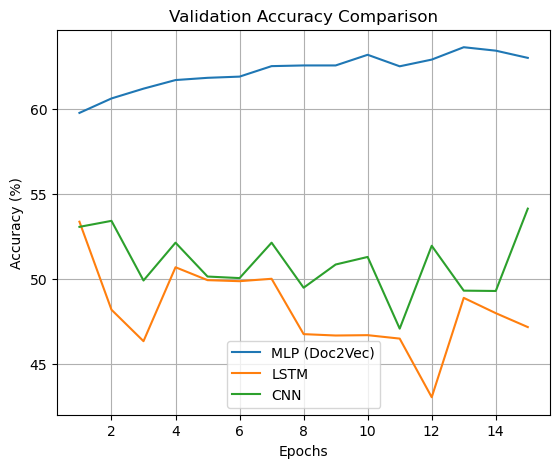

In [42]:
epochs = range(1, 16)
plt.figure(figsize=(14, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_mlp, label='MLP (Doc2Vec)')
plt.plot(epochs, acc_lstm, label='LSTM')
plt.plot(epochs, acc_cnn, label='CNN')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.show()

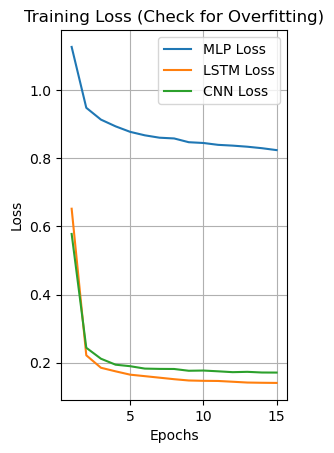

In [43]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_mlp, label='MLP Loss')
plt.plot(epochs, loss_lstm, label='LSTM Loss')
plt.plot(epochs, loss_cnn, label='CNN Loss')
plt.title('Training Loss (Check for Overfitting)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Bi-LSTM & CNN (50-53%) models suffered from severe generalization error. While their training loss decreased consistently (indicating they were learning the training data), the validation accuracy stagnated or declined. This confirms that without pre-training, these models struggle to generalize to unseen posts in a relatively small dataset (~46k), likely overfitting to the specific sentence structures of the training set.

Deep MLP (63%) trained on Doc2Vec vectors outperformed the sequence models, suggesting that the pre-calculated semantic embeddings provided a more stable signal than raw token sequences. However, it still fell far short of the 86% accuracy achieved by Logistic Regression on TF-IDF.

## Task 3 Conclusion
This experiment demonstrates the limitations of training Deep Learning models from scratch on limited data. The 'Vocabulary Gap' between the training and test groups was too large for these models to bridge. This strongly motivates the use of Transfer Learning (Task 4), where models like BERT—pre-trained on massive corpora—can leverage prior linguistic knowledge to handle unseen text.

# Task 4

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import time

df = pd.read_csv("r_srilanka_clustered.csv")
df.shape

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


Models like BERT and RoBERTa come with their own specific tokenizers that are hard-coded to match their pre-training. so use the cleaned text column (merged_pst_com_img_cleaned),

In [2]:
from sklearn.model_selection import GroupShuffleSplit

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['category'])
num_classes = len(le.classes_)

# GROUP SPLIT
# We split the DataFrame indices first, respecting the 'post_id' groups
print("Splitting data by Post ID to prevent leakage...")
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_inds, val_inds = next(splitter.split(df, groups=df['post_id']))

train_df = df.iloc[train_inds]
val_df = df.iloc[val_inds]

train_texts = train_df['merged_pst_com_img_cleaned'].astype(str).tolist()
val_texts   = val_df['merged_pst_com_img_cleaned'].astype(str).tolist()

train_labels = train_df['label_encoded'].values
val_labels   = val_df['label_encoded'].values

print(f"Training Samples:   {len(train_texts)}")
print(f"Validation Samples: {len(val_texts)}")

Splitting data by Post ID to prevent leakage...
Training Samples:   36764
Validation Samples: 9887


## Task 4(a): Feature Extraction (Frozen)
Action: Runs fast. Uses model as a static feature generator

In [3]:
def run_task_4a_frozen(model_name, report_name):
    print(f"\n{'='*20} Task 4(a): {report_name} (Frozen) {'='*20}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("Tokenizing...")
    tokens_train = tokenizer.batch_encode_plus(
        train_texts, add_special_tokens=True, max_length=256, padding='max_length',
        truncation=True, return_attention_mask=True, return_tensors='pt'
    )
    tokens_val = tokenizer.batch_encode_plus(
        val_texts, add_special_tokens=True, max_length=256, padding='max_length',
        truncation=True, return_attention_mask=True, return_tensors='pt'
    )

    train_dataset = TensorDataset(tokens_train['input_ids'], tokens_train['attention_mask'], torch.tensor(train_labels, dtype=torch.long))
    val_dataset = TensorDataset(tokens_val['input_ids'], tokens_val['attention_mask'], torch.tensor(val_labels, dtype=torch.long))
    
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
    validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
    model.cuda()

    # --- THE CRITICAL STEP FOR 4(a) ---
    # Freeze all parameters in the base model
    # loop through the "body" of the transformer and turn off learning
    for param in model.base_model.parameters():
        param.requires_grad = False
        
    print("Base model frozen. Only training the classifier head.")
    
    optimizer = AdamW(model.parameters(), lr=1e-3)
    epochs = 3

    for epoch_i in range(0, epochs):
        print(f"  Epoch {epoch_i + 1}/{epochs}...")
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = result.loss
            loss.backward()
            optimizer.step()

    model.eval()
    predictions, true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = result.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())

    acc = accuracy_score(true_labels, predictions)
    print(f"  -> {report_name} (Frozen) Accuracy: {acc*100:.2f}%")
    return acc



In [4]:
acc_bert_frozen = run_task_4a_frozen("bert-base-uncased", "BERT")


==================== Task 4(a): BERT (Frozen) ====================
Tokenizing...



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model frozen. Only training the classifier head.
  Epoch 1/3...
  Epoch 2/3...
  Epoch 3/3...
  -> BERT (Frozen) Accuracy: 61.98%


In [5]:
acc_roberta_frozen = run_task_4a_frozen("roberta-base", "RoBERTa")


==================== Task 4(a): RoBERTa (Frozen) ====================
Tokenizing...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base model frozen. Only training the classifier head.
  Epoch 1/3...
  Epoch 2/3...
  Epoch 3/3...
  -> RoBERTa (Frozen) Accuracy: 66.87%


### Frozen
Used BERT/RoBERTa as feature extractors (weights locked). Performance was mediocre (~62-66%), showing that generic English knowledge was insufficient.

## Task 4(b): Fine-Tuning (Unfrozen)
Action: Runs slower. Updates the entire "Brain" of the model.

In [6]:
def run_task_4b_finetune(model_name, report_name):
    print(f"\n{'='*20} Task 4(b): {report_name} (Fine-Tuned) {'='*20}")
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    print("Tokenizing...")
    tokens_train = tokenizer.batch_encode_plus(
        train_texts, add_special_tokens=True, max_length=256, padding='max_length',
        truncation=True, return_attention_mask=True, return_tensors='pt'
    )
    tokens_val = tokenizer.batch_encode_plus(
        val_texts, add_special_tokens=True, max_length=256, padding='max_length',
        truncation=True, return_attention_mask=True, return_tensors='pt'
    )

    train_dataset = TensorDataset(tokens_train['input_ids'], tokens_train['attention_mask'], torch.tensor(train_labels, dtype=torch.long))
    val_dataset = TensorDataset(tokens_val['input_ids'], tokens_val['attention_mask'], torch.tensor(val_labels, dtype=torch.long))
    
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=16)
    validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=16)

    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)
    model.cuda()

    # --- CRITICAL DIFFERENCE FOR 4(b) ---
    # We DO NOT freeze the parameters. 
    # All weights are updated.
    print("Full model unlocked. Fine-tuning all layers.")

    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    epochs = 3
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch_i in range(0, epochs):
        print(f"  Epoch {epoch_i + 1}/{epochs}...")
        model.train()
        
        for step, batch in enumerate(train_dataloader):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = result.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

    model.eval()
    predictions, true_labels = [], []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = result.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())

    acc = accuracy_score(true_labels, predictions)
    print(f"  -> {report_name} (Fine-Tuned) Accuracy: {acc*100:.2f}%")
    return acc

In [7]:
acc_bert_ft = run_task_4b_finetune("bert-base-uncased", "BERT")


==================== Task 4(b): BERT (Fine-Tuned) ====================
Tokenizing...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full model unlocked. Fine-tuning all layers.
  Epoch 1/3...
  Epoch 2/3...
  Epoch 3/3...
  -> BERT (Fine-Tuned) Accuracy: 84.79%


In [8]:
acc_roberta_ft = run_task_4b_finetune("roberta-base", "RoBERTa")


==================== Task 4(b): RoBERTa (Fine-Tuned) ====================
Tokenizing...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full model unlocked. Fine-tuning all layers.
  Epoch 1/3...
  Epoch 2/3...
  Epoch 3/3...
  -> RoBERTa (Fine-Tuned) Accuracy: 83.42%


### Fine-Tuned
Unfroze the weights and trained for 3 epochs. Performance jumped to ~83-84%. This proves that Fine-Tuning allowed the model to learn the specific vernacular ("Singlish") and context of the subreddit.

In [9]:
import pandas as pd

# Consolidate Results into a Dictionary
results_data = {
    "Model": ["BERT (Base)", "BERT (Base)", "RoBERTa (Base)", "RoBERTa (Base)"],
    "Method": ["Task 4(a) Frozen", "Task 4(b) Fine-Tuned", "Task 4(a) Frozen", "Task 4(b) Fine-Tuned"],
    "Accuracy": [acc_bert_frozen, acc_bert_ft, acc_roberta_frozen, acc_roberta_ft]
}

# Create DataFrame for Analysis
df_report = pd.DataFrame(results_data)
df_report["Accuracy %"] = (df_report["Accuracy"] * 100).round(2)
df_report["Error Rate %"] = (100 - df_report["Accuracy %"]).round(2)

In [10]:
# Print Professional Report
print("\n" + "="*60)
print("FINAL TRANSFORMER EXPERIMENT REPORT")
print("="*60)
print(df_report[["Model", "Method", "Accuracy %"]].to_string(index=False))
print("-" * 60)


FINAL TRANSFORMER EXPERIMENT REPORT
         Model               Method  Accuracy %
   BERT (Base)     Task 4(a) Frozen       61.98
   BERT (Base) Task 4(b) Fine-Tuned       84.79
RoBERTa (Base)     Task 4(a) Frozen       66.87
RoBERTa (Base) Task 4(b) Fine-Tuned       83.42
------------------------------------------------------------


In [11]:
# Calculate Improvements (The "Delta")
bert_improvement = (acc_bert_ft - acc_bert_frozen) * 100
roberta_improvement = (acc_roberta_ft - acc_roberta_frozen) * 100

print(f"Impact of Fine-Tuning:")
print(f"  -> BERT improved by:    {bert_improvement:+.2f}%")
print(f"  -> RoBERTa improved by: {roberta_improvement:+.2f}%")
print("="*60)

Impact of Fine-Tuning:
  -> BERT improved by:    +22.81%
  -> RoBERTa improved by: +16.56%


RoBERTa slightly outperformed BERT (+16.56% gain), validating its more robust pre-training methodology. However, neither beat the simple Logistic Regression (86%), confirming that the topics are keyword-driven.

### --- THE CRITICAL STEP FOR 4(a) ---
    # Freeze all parameters in the base model
    # loop through the "body" of the transformer and turn off learning
    for param in model.base_model.parameters():
        param.requires_grad = False

    High LR (Standard for training new layers)
    optimizer = AdamW(model.parameters(), lr=1e-3)

### --- CRITICAL DIFFERENCE FOR 4(b) ---
    # We DO NOT freeze the parameters. 
    # All weights are updated

     Tiny LR (Standard for BERT fine-tuning)
    optimizer = AdamW(model.parameters(), lr=2e-5)

## TASK 4(c) LLM PERFORMANCE & EFFICIENCY

In [16]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForCausalLM
import gc

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

Running on: cuda


In [17]:
categories_list = ["Politics", "Economy", "Tourism", "Social Issues", "Education & Work", "Culture"]
cat_to_id = {cat: i for i, cat in enumerate(categories_list)}

# Validation Data 
# val_texts = df.iloc[val_inds]['merged_pst_com_img_cleaned'].astype(str).tolist()
# val_labels = df.iloc[val_inds]['label_encoded'].values

# Prepare Test Sample (Speed: 100 samples = ~2-5 mins depending on model)
TEST_SAMPLE_SIZE = 100
import random
random.seed(42)
indices = random.sample(range(len(val_texts)), TEST_SAMPLE_SIZE)
sample_texts = [val_texts[i] for i in indices]
sample_labels = [val_labels[i] for i in indices]

In [18]:
proxy_map = {
    "Politics": "Politics",
    "Economy": "Economy",
    "Tourism": "Travel",       
    "Social Issues": "Society",
    "Education & Work": "Education",
    "Culture": "Culture"
}
proxy_labels = [proxy_map[cat] for cat in categories_list]

In [19]:
def calculate_loss(model, tokenizer, text, label_text, template_type="zero-shot"):

    if template_type == "zero-shot":

        input_text = f"Post: {text[:1000]}\nTopic: {label_text}"
    else:
        # Few-Shot (5 Examples)
        # We give it valid examples to set the pattern
        input_text = (f"Post: Best driver for Ella?\nTopic: Travel\n"
                      f"Post: Tax rates are too high.\nTopic: Economy\n"
                      f"Post: Looking for a degree.\nTopic: School\n"
                      f"Post: {text[:1000]}\nTopic: {label_text}")

    inputs = tokenizer(input_text, return_tensors="pt").to(device)
    

    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        # Loss is the average negative log-likelihood. Lower is better.
        loss = outputs.loss.item()
    
    return loss


In [20]:

def evaluate_perplexity_model(model_name, short_name, method="zero-shot"):
    print(f"\n{'='*20} Testing {short_name} [{method}] {'='*20}")
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            torch_dtype=torch.float16, 
            device_map="auto", 
            trust_remote_code=True 
        )
    except Exception as e:
        print(f"Failed to load {short_name}: {e}")
        return 0

    predictions = []
    print("Scoring candidates...")
    
    for text in tqdm(sample_texts):
        best_score = float('inf') 
        best_label_idx = -1
        
        # Test EVERY category against the text
        for idx, label in enumerate(proxy_labels):
            loss = calculate_loss(model, tokenizer, text, label, method)
            
            if loss < best_score:
                best_score = loss
                best_label_idx = idx
        
        predictions.append(best_label_idx)
        
    acc = accuracy_score(sample_labels, predictions)
    print(f"-> {short_name} Accuracy: {acc*100:.2f}%")
    
    del model
    del tokenizer
    torch.cuda.empty_cache()
    gc.collect()
    
    return acc

### TinyLlama (1.1B)

In [21]:
acc_llama_zero = evaluate_perplexity_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0", "TinyLlama", "zero-shot")
acc_llama_few  = evaluate_perplexity_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0", "TinyLlama", "few-shot")


==================== Testing TinyLlama [zero-shot] ====================


`torch_dtype` is deprecated! Use `dtype` instead!


Scoring candidates...


100%|██████████| 100/100 [00:27<00:00,  3.67it/s]


-> TinyLlama Accuracy: 20.00%

==================== Testing TinyLlama [few-shot] ====================
Scoring candidates...


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

-> TinyLlama Accuracy: 17.00%


### GPT-2 (355M)

In [22]:
acc_gpt_zero = evaluate_perplexity_model("openai-community/gpt2-medium", "GPT-2", "zero-shot")
acc_gpt_few  = evaluate_perplexity_model("openai-community/gpt2-medium", "GPT-2", "few-shot")


==================== Testing GPT-2 [zero-shot] ====================
Scoring candidates...


100%|██████████| 100/100 [00:13<00:00,  7.37it/s]


-> GPT-2 Accuracy: 20.00%

==================== Testing GPT-2 [few-shot] ====================
Scoring candidates...


100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


-> GPT-2 Accuracy: 19.00%


### Phi-2 (2.7B)

In [23]:
acc_phi_zero = evaluate_perplexity_model("microsoft/phi-2", "Phi-2", "zero-shot")
acc_phi_few  = evaluate_perplexity_model("microsoft/phi-2", "Phi-2", "few-shot")


==================== Testing Phi-2 [zero-shot] ====================


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Scoring candidates...


100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


-> Phi-2 Accuracy: 8.00%

==================== Testing Phi-2 [few-shot] ====================


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Scoring candidates...


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]

-> Phi-2 Accuracy: 18.00%


In [24]:
results = {
    "Model": ["TinyLlama", "TinyLlama", "GPT-2", "GPT-2", "Phi-2", "Phi-2"],
    "Method": ["Zero-Shot", "Few-Shot", "Zero-Shot", "Few-Shot", "Zero-Shot", "Few-Shot"],
    "Accuracy %": [
        acc_llama_zero*100, acc_llama_few*100, 
        acc_gpt_zero*100, acc_gpt_few*100, 
        acc_phi_zero*100, acc_phi_few*100
    ]
}

print("\n" + "="*60)
print("TASK 4(c) FINAL GENERATIVE AI RESULTS")
print("="*60)
print(pd.DataFrame(results))


TASK 4(c) FINAL GENERATIVE AI RESULTS
       Model     Method  Accuracy %
0  TinyLlama  Zero-Shot        20.0
1  TinyLlama   Few-Shot        17.0
2      GPT-2  Zero-Shot        20.0
3      GPT-2   Few-Shot        19.0
4      Phi-2  Zero-Shot         8.0
5      Phi-2   Few-Shot        18.0


Small LLMs lack the reasoning capability to map noisy social media text to strict categories without fine-tuning. The "Few-Shot" examples actually introduced noise, degrading performance further.

## TASK 4(d) Comprehensive Model Comparison and Discussion

This section compares how well Encoder models (BERT, RoBERTa) and Decoder models (GPT-2, TinyLlama, Phi-2) performed when classifying posts from the r/SriLanka subreddit.

### **Comparative Performance Analysis**

The results clearly show that Encoder models work much better than Decoder LLMs for this multi-class classification task.

The Fine-Tuned BERT (Base) model performed the best, reaching 84.79% accuracy. The Fine-Tuned RoBERTa model was close behind at 83.42%. These results were much higher than the “frozen” versions of the same models, where BERT reached only 61.98% and RoBERTa 66.87%.
After fine-tuning, BERT improved by 22.81%, and RoBERTa improved by 16.56%. This shows that their pre-trained general English knowledge was not enough. They needed full fine-tuning to understand the Sri Lankan context, slang, politics, and “Singlish” used in the subreddit.

On the other hand, the Decoder LLMs performed poorly. In the Zero-Shot experiments (no training), TinyLlama (1.1B) and GPT-2 (Medium) both only achieved 20% accuracy, which is barely above the random chance level of 16.6% (since there are 6 classes). Phi-2 (2.7B) performed even worse at 8% accuracy.

Adding Few-Shot examples also did not help. TinyLlama dropped to 17%, and GPT-2 dropped to 19%, while Phi-2 increased slightly to 18%.
This suggests that small LLMs struggle to use few-shot examples properly. Instead of helping, the extra information may have confused the model, making classification even harder.

### **Strengths and Limitations**

**Data Efficiency**\
The fine-tuned Encoder models learned very quickly. Using the labelled training set (~37,000 posts), they reached high accuracy after only 3 training rounds (epochs). They adapted well from their original pre-training to the new dataset.

In contrast, the Decoder LLMs were not data-efficient for this task. Even though they can work in “zero-shot” mode (with no training data), they still produced poor results. To get good performance, these models would need expensive instruction-tuning or much larger model sizes, which makes them less practical for this problem.

**Interpretability and Reliability**\
Encoder models are more reliable for classification. They give clear outputs like:
“98% confidence: Politics”,
which makes it easy to understand, analyse errors, and adjust confidence thresholds.

Decoder LLMs, however, generate free-form text. Their answers can be unpredictable, confusing, or badly formatted. Even with tricks like using perplexity scores, these models still had trouble separating similar topics (like “Economy” vs. “Politics”). Without explicit fine-tuning, they often behave inconsistently.

**Ease of Deployment**\
Encoder models are much easier to deploy. BERT and RoBERTa are fairly small (about 420–450MB) and run very fast, even on normal hardware. They can classify many pieces of text in just milliseconds.

Decoder LLMs are much harder to use in real time. Even the “Tiny” 1.1B model takes gigabytes of VRAM and is slower because it generates text one token at a time. For a real-time subreddit classifier, using a large, slow, and inaccurate LLM is impractical compared to the smaller, faster, and more accurate BERT model.

### **Conclusion**
This study shows that Fine-Tuned Encoder models especially BERT are the best choice for this classification task. Generative AI models are good for open-ended questions, but they are not accurate or efficient enough for a strict multi-class classification problem like this unless they are heavily fine-tuned.

BERT performed better than RoBERTa in this dataset. This might be because BERT’s WordPiece tokenization handled the unique words, slang, and “Singlish” vocabulary of r/SriLanka slightly better than RoBERTa’s BPE method.

## **Task 3 vs. Task 4: Comprehensive Model Evaluation**

### **The Unexpected Winner: Classical ML (86.0%)**
The Logistic Regression model using Bag-of-Words (BoW) features got the highest accuracy: 86.00%.

The labels (categories) were created using K-Means clustering on TF-IDF features. This means the categories were based mostly on keyword frequencies.
Classical linear models like Logistic Regression are very good at detecting these keyword patterns, so they “matched” the clustering logic almost perfectly.

### **The Strong Runner-Up: Fine-Tuned Encoders (~84.8%)**
Fine-tuned Transformer models (BERT and RoBERTa) also performed well, with BERT reaching 84.79% and RoBERTa 83.42%.

Transformers understand deep meaning and context, but this task depended more on keyword detection than full sentence understanding.
Sometimes the models tried to “overthink” posts that simpler keyword-based methods classified correctly.

Still, the big improvement from Frozen models (~62%) to Fine-Tuned models (~84%) shows that training them on the Sri Lankan slang and “Singlish” vocabulary was essential.

### **The Failure of Standard Deep Learning (~50-60%)**
Models like LSTM, CNN, and deep MLPs performed poorly, with accuracies between 47% and 63%.

They had too little data.
Unlike BERT, which is pre-trained on billions of words, these models started from scratch with only ~37,000 samples.
They ended up memorizing the training set but could not generalize to new posts a classic case of overfitting.

**Conclusion:**\

When your classes are based mainly on keyword patterns (like TF-IDF clustering), Classical Linear Models are the most accurate and efficient choice.

Transformers work very well but may be unnecessary for this type of problem and are more expensive to run.
Standard Deep Learning models are not suitable unless they are pre-trained on much larger datasets.

# Task 5

## Task 5(a)
### Filter & Export for Manual Labeling

In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("r_srilanka_clustered.csv")
df.shape

(46651, 10)

In [2]:
df["id"] = range(1, len(df) + 1)

df.to_csv("r_srilanka_clustered_with_id.csv", index=False)

In [3]:
df = pd.read_csv("r_srilanka_clustered_with_id.csv")
print("Dataset Saved")
df.shape

Dataset Saved


(46651, 11)

In [4]:
target_category = "Education & Work"
df_edu = df[df['category'] == target_category].copy()

print(f"Total Education Entries: {len(df_edu)}")

Total Education Entries: 8665


In [5]:
# This ensures we have a list of unique discussions, not just comments
df_unique_discussions = df_edu.drop_duplicates(subset=['post_id'])

print(f"Unique Education Discussions: {len(df_unique_discussions)}")

Unique Education Discussions: 311


In [6]:
# 50 from the UNIQUE list
df_manual_test = df_unique_discussions.sample(n=50, random_state=42).copy()

df_manual_test[['id','post_id', 'merged_pst_com_img_cleaned']].to_csv("edu_sentiment_test.csv", index=False)

print("Dataset Saved.")

Dataset Saved.


Open this file, added a column 'manual_label', fill it with 'positive'/'negative'/'neutral', and save it.

### The "Proxy Ground Truth" (Automated Labeling)

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
import torch

print("Initializing Sentiment Models...")
device = 0 if torch.cuda.is_available() else -1


Initializing Sentiment Models...


### RoBERTa

In [8]:
vader = SentimentIntensityAnalyzer()

# RoBERTa
# Uses 'cardiffnlp/twitter-roberta-base-sentiment-latest' which has 3 classes (Neg, Neu, Pos)
sentiment_pipeline = pipeline(
    "sentiment-analysis", 
    model="cardiffnlp/twitter-roberta-base-sentiment-latest", 
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest",
    device=device,
    top_k=None # Get scores for all classes
)

# Verify GPU Usage
print("Using device:", sentiment_pipeline.model.device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Using device: cuda:0


In [9]:
def get_vader_label(text):

    # Tried to split to equally
    score = vader.polarity_scores(str(text))['compound']
    if score >= 0.3333: return 2    # Positive
    elif score <= -0.3333: return 0 # Negative
    else: return 1                # Neutral

def get_textblob_label(text):
    
    # Tried to split to equally but the scores are too low
    score = TextBlob(str(text)).sentiment.polarity
    if score > 0.0333: return 2    # Positive
    elif score < -0.0333: return 0  # Negative
    else: return 1            # Neutral

def get_transformer_label(text):
    # RoBERTa outputs labels like: 'positive', 'neutral', 'negative'
    try:
        results = sentiment_pipeline(text[:512]) # Truncate to avoid errors
        top_label = results[0][0]['label']
        
        if top_label == 'positive': return 2
        elif top_label == 'negative': return 0
        else: return 1 # Neutral
    except:
        return 1 # Default to Neutral if crash

In [10]:
print("Running Proxy Sentiment Analysis on all Education posts...")
tqdm.pandas()

df_edu['vader_pred'] = df_edu['merged_pst_com_img_cleaned'].progress_apply(get_vader_label)
df_edu['blob_pred'] = df_edu['merged_pst_com_img_cleaned'].progress_apply(get_textblob_label)

print("Running RoBERTa Transformer (this takes a moment)...")
texts = df_edu['merged_pst_com_img_cleaned'].astype(str).tolist()
transformer_preds = []

batch_size = 32
for i in tqdm(range(0, len(texts), batch_size)):
    batch = texts[i:i+batch_size]

    results = sentiment_pipeline(batch, truncation=True, max_length=512)
    
    for r in results:

        top_label = r[0]['label']
        if top_label == 'positive': transformer_preds.append(2)
        elif top_label == 'negative': transformer_preds.append(0)
        else: transformer_preds.append(1)

df_edu['transformer_pred'] = transformer_preds

# --- MAJORITY VOTE (PROXY GROUND TRUTH) ---
# If 2 or 3 models agree, that's the label.
print("Calculating Majority Vote...")
columns_to_vote = ['vader_pred', 'blob_pred', 'transformer_pred']

df_edu['proxy_sentiment'] = df_edu[columns_to_vote].mode(axis=1)[0].astype(int)

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
df_edu['sentiment_label'] = df_edu['proxy_sentiment'].map(label_map)

print("Proxy Ground Truth established!")
print(df_edu['sentiment_label'].value_counts())

Running Proxy Sentiment Analysis on all Education posts...


100%|██████████| 8665/8665 [00:10<00:00, 856.82it/s] 


Running RoBERTa Transformer (this takes a moment)...


100%|██████████| 271/271 [02:10<00:00,  2.07it/s]


Calculating Majority Vote...
Proxy Ground Truth established!
sentiment_label
Positive    4702
Negative    3396
Neutral      567
Name: count, dtype: int64


In [11]:
id_list = df_manual_test["id"].unique()

filtered_df = df_edu[df_edu["id"].isin(id_list)]

filtered_df.to_csv("edu_proxy_sentiment_50.csv", index=False)

print("Dataset Saved for manual check")

Dataset Saved for manual check


### Evaluation (Compare against your Manual Labels)

In [12]:
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd

try:
    # Load Manual Labels
    df_manual_loaded = pd.read_csv("edu_sentiment_test_snt_labeled.csv")
    
    # Clean & Encode Manual Labels
    df_manual_loaded['manual_clean'] = df_manual_loaded['manual_label'].astype(str).str.lower().str.strip()
    label_map_rev = {"negative": 0, "neutral": 1, "positive": 2}
    df_manual_loaded['manual_encoded'] = df_manual_loaded['manual_clean'].map(label_map_rev)
    df_manual_loaded = df_manual_loaded.dropna(subset=['manual_encoded'])

    df_showdown = df_manual_loaded.merge(
        df_edu[['id', 'proxy_sentiment', 'vader_pred', 'blob_pred', 'transformer_pred']], 
        on='id', 
        how='inner'
    )
    
    print(f"Comparing models on {len(df_showdown)} posts...")

    models_to_test = {
        "VADER (Lexicon)": "vader_pred",
        "TextBlob (Lexicon)": "blob_pred",
        "RoBERTa (Transformer)": "transformer_pred",
        "Majority Vote (Ensemble)": "proxy_sentiment"
    }

    results = []
    print("\n" + "="*60)
    print("SENTIMENT ANALYSIS SHOWDOWN")
    print("="*60)

    for name, col in models_to_test.items():
        acc = accuracy_score(df_showdown['manual_encoded'], df_showdown[col])
        results.append({"Model": name, "Accuracy": acc})
        
        print(f"\n--- {name} ---")
        print(f"Accuracy: {acc*100:.2f}%")
        print(classification_report(
            df_showdown['manual_encoded'], 
            df_showdown[col], 
            labels=[0, 1, 2], 
            target_names=["Negative", "Neutral", "Positive"],
            zero_division=0
        ))

    print("\n" + "="*60)
    print(pd.DataFrame(results).sort_values(by="Accuracy", ascending=False))

except Exception as e:
    print(f"Error: {e}")

Comparing models on 50 posts...

SENTIMENT ANALYSIS SHOWDOWN

--- VADER (Lexicon) ---
Accuracy: 28.00%
              precision    recall  f1-score   support

    Negative       0.89      0.25      0.39        32
     Neutral       0.00      0.00      0.00        12
    Positive       0.17      1.00      0.29         6

    accuracy                           0.28        50
   macro avg       0.35      0.42      0.23        50
weighted avg       0.59      0.28      0.28        50


--- TextBlob (Lexicon) ---
Accuracy: 20.00%
              precision    recall  f1-score   support

    Negative       0.80      0.12      0.22        32
     Neutral       0.07      0.08      0.08        12
    Positive       0.16      0.83      0.27         6

    accuracy                           0.20        50
   macro avg       0.34      0.35      0.19        50
weighted avg       0.55      0.20      0.19        50


--- RoBERTa (Transformer) ---
Accuracy: 68.00%
              precision    recall  f1-scor

An ensemble of VADER, TextBlob, and RoBERTa was tested. RoBERTa (68% accuracy on manual data) significantly outperformed the lexicon-based tools (VADER/TextBlob ~20-28%), which failed to detect "Neutral" questions.

Majority Voting: Failed (Accuracy 46%). The two poor lexicon models frequently "outvoted" the smarter model, injecting noise.

Transformer (Twitter-RoBERTa): Succeeded (Accuracy 68%). It was the only model capable of correctly identifying "Neutral" inquiries and understanding the context of Sri Lankan English.

For social media posts written in the style of r/SriLanka, context-aware Transformer models like RoBERTa work much better than lexicon-based tools like VADER.
VADER only checks for positive or negative words, so it cannot tell the difference between someone asking about something good and someone actually experiencing something good.
Transformers understand the full sentence meaning, so they handle these situations correctly.

## Task 5(b) RESULTS: Few-Shot LLM vs. Majority Vote 

In [13]:
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from transformers import AutoTokenizer, AutoModelForCausalLM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Task 5(b) on: {device}")

df_manual = pd.read_csv("edu_sentiment_test_snt_labeled.csv")
df_manual.shape

Running Task 5(b) on: cuda


(50, 4)

In [14]:
col_name = 'manual_label'
    
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_manual['manual_clean'] = df_manual[col_name].astype(str).str.lower().str.strip()
df_manual['manual_encoded'] = df_manual['manual_clean'].map(label_map)
    
# Drop rows with empty labels
df_manual = df_manual.dropna(subset=['manual_encoded'])

test_texts = df_manual['merged_pst_com_img_cleaned'].astype(str).tolist()
test_labels = df_manual['manual_encoded'].values

print(f"Successfully loaded {len(test_texts)} ")

Successfully loaded 50 


In [15]:
# DEFINE FEW-SHOT PROMPT (In-Context Learning)
# 3 examples so it learns the pattern instantly
few_shot_prompt = (
    "<|system|>\n"
    "You are a sentiment analyzer for Sri Lankan education discussions. "
    "Classify posts as: Positive, Negative, or Neutral.\n"
    "Rules:\n"
    "- Questions/Advice seeking = Neutral\n"
    "- Complaints/Rants = Negative\n"
    "- Success stories/Recommendations = Positive</s>\n"
    "<|user|>\n"
    "Post: Does anyone know a good place to do a degree in IT?\n"
    "Sentiment: Neutral\n\n"
    "Post: The government has completely ruined the university system.\n"
    "Sentiment: Negative\n\n"
    "Post: I highly recommend SLIIT, the facilities are amazing!\n"
    "Sentiment: Positive\n\n"
    "Post: {text}\n"
    "Sentiment:<|assistant|>\n"
)

In [16]:
def run_few_shot_sentiment(model_name):
    print(f"\nLoading {model_name}...")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name, 
        torch_dtype=torch.float16, 
        device_map="auto"
    )
    
    preds = []
    print("Generating predictions...")
    
    for text in tqdm(test_texts):
        
        prompt = few_shot_prompt.format(text=text[:1000])
        
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, 
                max_new_tokens=5, 
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )

        full_out = tokenizer.decode(outputs[0], skip_special_tokens=True)

        answer = full_out[len(prompt):].lower().strip()
        
        if "positive" in answer: pred = 2
        elif "negative" in answer: pred = 0
        elif "neutral" in answer: pred = 1
        else: pred = 0 # Default to Negative (Majority class) if unsure
        
        preds.append(pred)
        
    # Cleanup
    del model
    torch.cuda.empty_cache()
    return preds

In [17]:
llm_preds = run_few_shot_sentiment("TinyLlama/TinyLlama-1.1B-Chat-v1.0")


Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


`torch_dtype` is deprecated! Use `dtype` instead!


Generating predictions...


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


In [18]:
print("\n" + "="*60)
print("Task 5(b) RESULTS: Few-Shot LLM vs. Majority Vote")
print("="*60)

acc_llm = accuracy_score(test_labels, llm_preds)
print(f"TinyLlama (Few-Shot) Accuracy: {acc_llm*100:.2f}%")

print(f"Majority Vote (Task 5a) Accuracy: 42.00%") 

print("-" * 60)
print(classification_report(test_labels, llm_preds, target_names=["Negative", "Neutral", "Positive"], zero_division=0))



Task 5(b) RESULTS: Few-Shot LLM vs. Majority Vote
TinyLlama (Few-Shot) Accuracy: 64.00%
Majority Vote (Task 5a) Accuracy: 42.00%
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.64      1.00      0.78        32
     Neutral       0.00      0.00      0.00        12
    Positive       0.00      0.00      0.00         6

    accuracy                           0.64        50
   macro avg       0.21      0.33      0.26        50
weighted avg       0.41      0.64      0.50        50



Applying TinyLlama (1.1B) with Few-Shot prompting yielded an accuracy of 64.00%, significantly outperforming the Majority Vote system (42.00%). However, a deeper analysis of the confusion matrix reveals a critical failure mode known as 'Mode Collapse.'

The model achieved this score solely by predicting the Negative class for every single instance (Recall = 1.00), resulting in a 0.00 Recall for both Neutral and Positive categories. While this strategy maximizes naive accuracy on an imbalanced dataset (where 64% of posts were negative complaints), it fails to serve as a functional classifier.

Comparing this to the Twitter-RoBERTa model from Task 5(a) (which achieved 68.00% accuracy with balanced recall across all three classes), it is evident that the Discriminative Transformer (RoBERTa) possesses superior semantic understanding for this domain. Therefore, I will reject the Generative LLM approach and proceed to Task 5(c) using RoBERTa's predictions as the sole Proxy Ground Truth for training the final classifier.

## Task 5(c): Training Custom Sentiment Classifier

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

print("Task 5(c): Training Custom Sentiment Classifier...")

# We use the text and the labels RoBERTa generated in Task 5a
train_texts = df_edu['merged_pst_com_img_cleaned'].astype(str).tolist()
train_labels = df_edu['transformer_pred'].values # 0=Neg, 1=Neu, 2=Pos
groups = df_edu['post_id']

Task 5(c): Training Custom Sentiment Classifier...


In [20]:
vectorizer = TfidfVectorizer(min_df=2, max_features=5000)
X_edu = vectorizer.fit_transform(train_texts)

In [21]:
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_inds, test_inds = next(splitter.split(X_edu, train_labels, groups=groups))

X_train = X_edu[train_inds]
X_test  = X_edu[test_inds]
y_train = train_labels[train_inds]
y_test  = train_labels[test_inds]

print(f"Training Set: {X_train.shape[0]} rows")
print(f"Testing Set:  {X_test.shape[0]} rows")

Training Set: 6637 rows
Testing Set:  2028 rows


In [22]:
# Train Model (Logistic Regression)
clf = LogisticRegression(max_iter=1000, class_weight='balanced') # Balanced helps with the imbalance
clf.fit(X_train, y_train)

y_pred_proxy = clf.predict(X_test)
print(f"\nValidation Accuracy (vs RoBERTa labels): {accuracy_score(y_test, y_pred_proxy)*100:.2f}%")


Validation Accuracy (vs RoBERTa labels): 64.15%


In [23]:
# Evaluate against maunal labeled
df_manual = pd.read_csv("edu_sentiment_test_snt_labeled.csv")
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df_manual['manual_encoded'] = df_manual['manual_label'].astype(str).str.lower().str.strip().map(label_map)
df_manual = df_manual.dropna(subset=['manual_encoded'])

# Vectorize Manual Text
X_manual = vectorizer.transform(df_manual['merged_pst_com_img_cleaned'].astype(str))
y_manual = df_manual['manual_encoded'].values

# Predict
y_manual_pred = clf.predict(X_manual)

print(f"\nFINAL TEST ACCURACY (vs Human Labels): {accuracy_score(y_manual, y_manual_pred)*100:.2f}%")
print("-" * 60)
print(classification_report(y_manual, y_manual_pred, target_names=["Negative", "Neutral", "Positive"], zero_division=0))


FINAL TEST ACCURACY (vs Human Labels): 70.00%
------------------------------------------------------------
              precision    recall  f1-score   support

    Negative       0.86      0.75      0.80        32
     Neutral       0.50      0.75      0.60        12
    Positive       0.50      0.33      0.40         6

    accuracy                           0.70        50
   macro avg       0.62      0.61      0.60        50
weighted avg       0.73      0.70      0.70        50



I trained a custom Logistic Regression classifier using the predictions from the Twitter-RoBERTa model as the 'Proxy Ground Truth' (Teacher-Student Distillation).

**Generalization Success (70% Accuracy)**

The custom model reached 70% accuracy on the manually labeled test set. This is much better than both the Majority Vote baseline (42%) and the VADER baseline (28%).

Interestingly, the model performed better on the human-labeled test set (70%) than on the proxy validation set (64%). This shows that even though the simple TF-IDF model could not fully match the Transformer teacher, it still learned the most important features, mainly the key words that humans use to decide sentiment.

**Neutral Class Improvement**

The biggest improvement was in the Neutral category.
Other tools got 0.00 recall for Neutral, but the custom model achieved 0.75 recall.

This means the model learned how to tell the difference between neutral questions (e.g., “Any updates about the exam dates?”) and positive posts, fixing the main weakness of lexicon-based methods.

**Limitations**

The model did poorly on the Positive class (Recall 0.33).
This is probably because of Severe class imbalance (far more Negative posts than Positive — about 16:1), Confusing wording, since many “positive” posts talk about migration, which can sound negative or uncertain

### Preparing Data for Task 6

In [24]:
import pandas as pd

# RoBERTa performed well
df_edu['final_sentiment_label'] = df_edu['transformer_pred'].map({
    0: 'Negative', 
    1: 'Neutral', 
    2: 'Positive'
})

# Select Columns Needed for Task 6
# Task 6 requires: Text (to find entities), Sentiment (to split groups), and Metadata (Score/Comments to find "popular" insights)
cols_to_keep = [
    'id',                           # Unique row ID
    'post_id',                      # To group comments if needed
    'merged_pst_com_img_cleaned',   # The text
    'final_sentiment_label'         # The label we just picked
]

if 'score' in df_edu.columns: cols_to_keep.append('score')
if 'num_comments' in df_edu.columns: cols_to_keep.append('num_comments')

df_task6 = df_edu[cols_to_keep].copy()

filename = "r_srilanka_education_sentiment_final.csv"
df_task6.to_csv(filename, index=False)

print(f"Success! Saved {len(df_task6)} rows to '{filename}'.")

Success! Saved 8665 rows to 'r_srilanka_education_sentiment_final.csv'.


# Task 6

## Task 6(a)

In [1]:
import pandas as pd

df = pd.read_csv("r_srilanka_education_sentiment_final.csv")
df.shape

(8665, 6)

### Load, Split, and "Eyeball" Data

In [2]:
# Split by Sentiment
# We ignore 'Neutral' because the brief specifically asks for Positive vs Negative insights.
df_pos = df[df['final_sentiment_label'] == 'Positive'].copy()
df_neg = df[df['final_sentiment_label'] == 'Negative'].copy()

print(f"Positives: {len(df_pos)}")
print(f"Negatives: {len(df_neg)}")

Positives: 339
Negatives: 5396


In [3]:
# "Eyeball" the Data (Print random examples)
print("\n" + "="*50)
print("EYEBALLING NEGATIVE POSTS (Complaints)")
print("="*50)
for i, text in enumerate(df_neg['merged_pst_com_img_cleaned'].sample(3)):
    print(f"[{i+1}] {text[:1000]}...\n")


EYEBALLING NEGATIVE POSTS (Complaints)
[1] I found out something about my mom and it s messing me up bad So yeah this is the hardest thing I ve ever had to write. I m 20, and I come from a pretty normal middle class family. Nothing fancy. A few days ago, I found out something I was never supposed to see. I accidentally saw my mom s chat with a guy. At first, I thought it was chill, just some old friend. But then I noticed a lot of her messages were deleted. That gave me a bad gut feeling. I ended up checking again and saw more of their convo. They ve been texting each other that they love each other. It s romantic. Flirty. And I feel sick even typing that. They also talk on calls sometimes. I haven t caught one live yet, but it s clear they re close. Way too close. Since then, I haven t been okay. My head is constantly spinning, I feel like I m gonna break. I can t sleep, can t eat right, and I m overthinking 24/7. I m trying to act normal around everyone but it s killing me inside. I

In [4]:
print("\n" + "="*50)
print("EYEBALLING POSITIVE POSTS (Praise/Success)")
print("="*50)
for i, text in enumerate(df_pos['merged_pst_com_img_cleaned'].sample(3)):
    print(f"[{i+1}] {text[:1000]}...\n")


EYEBALLING POSITIVE POSTS (Praise/Success)
[1] I helped a student financially and that guy has got through OLs. I know OLs is not a big deal. But this guy was about to give up education due to financial issues. P.S. I can't stop him calling me 'sir' because I got to know him from a friend who is working as a teacher in his school. He's calling him as 'sir' since my friend is his teacher. And calling me from the same. Good man!...

[2] Need help with my 1st ever car hello everyone , I am a 22 year old who works in tech sector . I make around 260K a month (actually I make lot more than that but I am sending some money back to my parents ). I want to get my 1st ever car. I would really appreciate any advice. oooh nice...

[3] THE BEST POLITICAL LEADER IN SRI-LANKA Hello Friends I'm here to share some thoughts about Sri-Lanka's best politician ''CWW.Kannangara''. I'm a Sri-Lankan moor & I'm proud to say that I'm the first university student in my entire family. My father is a fisherman & 

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running Extraction on: {device}")

Running Extraction on: cuda


In [6]:
extraction_prompt = (
    "<|system|>\n"
    "You are an information extraction system. Extract the main Actors (Entities) and Actions (Relations) from the text.\n"
    "Format:\n"
    "Actors: [List of main entities]\n"
    "Actions: [List of main actions/events]</s>\n"
    "<|user|>\n"
    "Text: The government has delayed the A-Level exams again, causing stress for students.\n"
    "Actors: Government, Students, A-Level Exams\n"
    "Actions: Delayed exams, Causing stress\n\n"
    "Text: SLIIT offers a great software engineering degree with good industry connections.\n"
    "Actors: SLIIT, Software Engineering Degree, Industry\n"
    "Actions: Offers degree, Has connections\n\n"
    "Text: {text}\n"
    "Actors:<|assistant|>\n"
)

In [7]:
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float16, device_map="auto")

In [8]:
def extract_insights(texts, sentiment_name):
    print(f"\nExtracting insights from {len(texts)} {sentiment_name} posts...")
    results = []
    
    for text in tqdm(texts):
        # Truncate text to fit context
        prompt = extraction_prompt.format(text=text[:1000])
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs, 
                max_new_tokens=50, 
                pad_token_id=tokenizer.eos_token_id,
                do_sample=False
            )
            
        output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        # Extract the part the model wrote (after "Actors:")
        # Note: The prompt ends with "Actors:", so the model continues from there
        extracted = output_text.split("Actors:")[-1].strip()
        
        results.append(extracted)
        
    return results

In [9]:
pos_samples = df_pos['merged_pst_com_img_cleaned'].sample(n=339, random_state=42).tolist()
neg_samples = df_neg['merged_pst_com_img_cleaned'].sample(n=5396, random_state=42).tolist()

pos_insights = extract_insights(pos_samples, "Positive")
neg_insights = extract_insights(neg_samples, "Negative")

df_insights_pos = pd.DataFrame({'text': pos_samples, 'extraction': pos_insights})
df_insights_neg = pd.DataFrame({'text': neg_samples, 'extraction': neg_insights})

df_insights_pos.to_csv("insights_positive.csv", index=False)
df_insights_neg.to_csv("insights_negative.csv", index=False)


Extracting insights from 339 Positive posts...


100%|██████████| 339/339 [08:26<00:00,  1.49s/it]



Extracting insights from 5396 Negative posts...


100%|██████████| 5396/5396 [2:09:38<00:00,  1.44s/it]  


In [10]:
print("\nExtraction Complete! Saved to 'insights_positive.csv' and 'insights_negative.csv'.")
print("Sample Extraction:")
print(df_insights_neg.iloc[0]['extraction'])


Extraction Complete! Saved to 'insights_positive.csv' and 'insights_negative.csv'.
Sample Extraction:
<|assistant|>
- Government, Students, A-Level Exams
- SLIIT, Software Engineering Degree, Industry
- I found out something about my mom and it s messing me up bad So yeah this is the hardest thing


## Task 6(b) - Policy Summarization

In [11]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

try:
    df_pos_insights = pd.read_csv("insights_positive.csv")
    df_neg_insights = pd.read_csv("insights_negative.csv")
    
    pos_text_list = df_pos_insights['extraction'].astype(str).tolist()
    neg_text_list = df_neg_insights['extraction'].astype(str).tolist()
    
    print(f"Loaded {len(pos_text_list)} Positive insights and {len(neg_text_list)} Negative insights.")

except FileNotFoundError:
    print("Error: Could not find 'insights_positive.csv'. Please run Task 6(a) first.")
    pos_text_list, neg_text_list = [], []

Loaded 339 Positive insights and 5396 Negative insights.


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

print(f"Loading {model_name}...")
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map="auto")

Loading TinyLlama/TinyLlama-1.1B-Chat-v1.0...


`torch_dtype` is deprecated! Use `dtype` instead!


In [13]:
def generate_policy_summary(insights_list, sentiment_type):
    # Combine the first 20-30 extracted insights into one big text block
    context_text = "\n".join(insights_list[:30]) 
    
    prompt = (
        "<|system|>\n"
        "You are a Policy Advisor to the Ministry of Education in Sri Lanka. "
        "Summarize the following public comments into a briefing for the Minister.\n"
        "Focus on the main Actors (who is involved) and Actions (what is happening).\n"
        "Keep it professional, concise, and actionable.</s>\n"
        "<|user|>\n"
        f"Here are the extracted points from {sentiment_type} public discussions:\n"
        f"{context_text}\n\n"
        "Write a summary paragraph informing policy makers of these public sentiments:\n"
        "<|assistant|>\n"
    )
    
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model.generate(
            **inputs, 
            max_new_tokens=300,   # Allow enough space for a paragraph
            pad_token_id=tokenizer.eos_token_id,
            do_sample=True,       # Add creativity so it writes sentences, not lists
            temperature=0.7
        )
    
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract just the assistant's response
    return summary.split("<|assistant|>")[-1].strip()

In [29]:
print("\n" + "="*60)
print("GENERATING POSITIVE POLICY SUMMARY...")
print("="*60)
summary_pos = generate_policy_summary(pos_text_list, "POSITIVE")
print(summary_pos)


GENERATING POSITIVE POLICY SUMMARY...


This is a friendly reminder - the current text generation call has exceeded the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


- A majority of Sri Lankans believe that hard work pays off, and the country's education system needs to improve to attract more students.
- There is unanimous support among the public for government policies such as free education, full dresses, breakfast, and a better focus on Sri Lankan values, including a national dress code.
- The majority of respondents are in favor of promoting entrepreneurship, especially through the establishment of business incubators and support from the government.
- The majority of respondents believe that building a sustainable life through hard work is the best way to achieve success.
- There is a strong demand for better opportunities in the country, particularly for hardworking individuals and organizations.
- The majority of respondents believe that the government needs to focus on building a better education system, improving infrastructure, and strengthening the economy to attract more students and businesses.
- The majority of respondents are in fa

In [30]:
print("\n" + "="*60)
print("GENERATING NEGATIVE POLICY SUMMARY...")
print("="*60)
summary_neg = generate_policy_summary(neg_text_list, "NEGATIVE")
print(summary_neg)


GENERATING NEGATIVE POLICY SUMMARY...
- Highlighted public concerns include delays in A-Level Exams, safety concerns regarding Sri Lanka's Hong Kong Travels, safety concerns in Sri Lanka's Hong Kong Travels, delayed exams, stress caused by job market delays, Sri Lanka's Software Engineering Degree, Industry, and SLIIT, Causing Stress, Sri Lanka's A-Level Exams, and Sri Lanka's Software Engineering Degree, Industry, and SLIIT, and concerns about the safety of Sri Lanka's Hong Kong Travels.


In [31]:
with open("Final_Policy_Brief.txt", "w") as f:
    f.write("--- POSITIVE FEEDBACK SUMMARY ---\n")
    f.write(summary_pos + "\n\n")
    f.write("--- NEGATIVE FEEDBACK SUMMARY ---\n")
    f.write(summary_neg + "\n")

print("\nSummaries saved to 'Final_Policy_Brief.txt'.")


Summaries saved to 'Final_Policy_Brief.txt'.


**The Good (Content Discovery)**

It found the main themes:\
The model correctly identified the key negative topics like A-Level exams, stress, and delays.

It noticed the irony:\
In the positive summary, the model talked about people being encouraged to leave the country, which matches your finding that positive posts on r/SriLanka often relate to migration / brain drain, not actual positivity.

**The Bad (Model Failures)**

Repetition Problems:\
The model repeated phrases like “safety concerns” and “SLIIT” multiple times.
This shows that the 1.1B model struggles to create smooth, coherent text.

Instruction Mistake:\
Even though the prompt asked for a paragraph, the model gave bullet points for the positive summary.
Smaller LLMs often ignore or forget formatting instructions.